# Dorothea

There are two ways of describing the city of Dorothea: you can say that four aluminum towers rise from its walls flanking seven gates with spring-operated drawbridges that span the moat whose water feeds four green canals which cross the city, dividing it into nine quarters, each with three hundred houses and seven hundred chimneys. And bearing in mind that the nubile girls of each quarter marry youths of other quarters and their parents exchange the goods that each family holds in monopoly -- bergamot, sturgeon roe, astrolabes, amethysts -- you can then work from these facts until you learn everything you wish about the city in the past, present, and future. Or else you can say, like the camel driver who took me there: “I arrived here in my first youth, one morning, many people were hurrying along the streets toward the market, the women had fine teeth and looked you straight in the eye, three soldiers on a platform played the trumpet, and all around wheels turned and colored banners fluttered in the wind. Before then I had known only the desert and the caravan routes. In the years that followed, my eyes returned to contemplate the desert expanses and the caravan routes; but now I know this path is only one of the many that opened before me on that morning in Dorothea.”

In [1]:
from __future__ import print_function

In [2]:
from IPython.display import Image

In [3]:
%matplotlib inline

In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

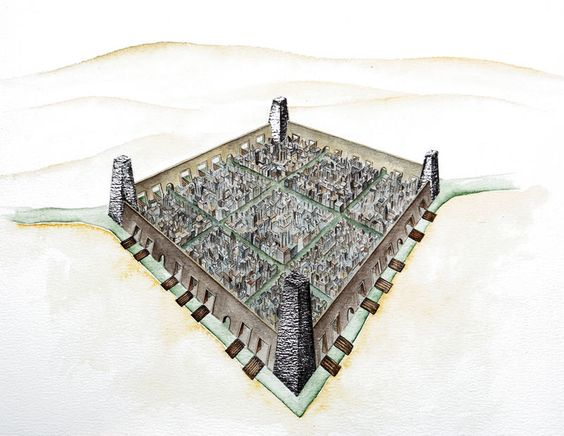

In [6]:
Image(filename='../../Images/Dorothea.jpg') 

## DOROTEA-PMAPS

### Functions to compute PMAPS and save them to a DST file


### The concept of PMAP

A PMAP puts together the EP and TP information relevant for high-level reconstruction.

The core of the PMAP concept is the realization that the NEXT event can be organized in terms of the time bins of event's S2s. 

The first step to build a PMAP is to add the information of all the PMTs, thus increasing the statistical significance. The steps are as follows:

1. Add the CWF of each PMT, to form the SWF, dividing each CWF by its corresponding calibration constant (adc to pes).
2. Zero-supression in the SWF, imposing a threshold of (tipically) 3*sigma*noise
3. From S12 "peaks" by collecting bins with energy above threshold which are grouped in a contiguous series (the contiguity is defined by a stride that does not need to be one). In fact, a large stride is used, since the PMT DAQ sampling (each 25 ns) is too fast for the detector physics (1 mus = 1 mm). The SiPMs are read out each 1 mus. Thus, the stride used (which defines the notion of contiguity) is 40 (25 ns --> 1 mus).
4. S1 is easily identified as a narrow peak with a few pes integral. t0 is extracted from S1.
5. Often, the events have a single S2, but two or more S2s are possible. Each S2 defines tipically a different "particle" or "track" in the event. 

Once the list of S2s obtained from the SWF is in hand, the algorithm proceeds as follows:

1. For each S2 in the SWF, select the corresponding S2 in each of the 12 PMTs. 
2. The collection of t0, SWF S2s and EP S2s forms an EP PMAP.

The next step is to add the SiPM information. The steps are as follows:

1. For each S2 in the SWF, find the corresponding S2 in each SiPM (search the waveforms only in the range defined by the SWF S2s and impose a trheshold cut). Each S2 thus found in the TP is called a sipms2. The collection of all the sipms2 are a sipms2p.

Finally, a PMAP is the collection of the EP PMAP and SIPMS2P. 

In [7]:
import logging
import sys
logger = logging.getLogger()
logger.handlers[0].stream = sys.stdout
logger.setLevel(logging.DEBUG)

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np

In [9]:
import mplFunctions as mpl
jotdown 
import sensorFunctions as SF
from Util import *

In [10]:
import FEParam as FP
import time
from time import time

### Nominal calibration constant (adc_per_pes)

http://localhost:8989/notebooks/SIERPE.ipynb

In [11]:
adc_to_pes = 18.07  # in the MC this is fixed for all PMTs, in data it comes from calibration

In [12]:
% ls /Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/

WF_Na_0_RWF.h5                   WF_Na_ZLIB_offset500_RWF.h5
WF_Na_1k.h5                      WF_Na_ZLIB_test2_RWF.h5
WF_Na_1k_RWF.h5                  WF_Na_ZLIB_test_RWF.h5
WF_Na_BLOSC_float32_RWF.h5       WF_Na_test_RWF.h5
WF_Na_BLOSC_test2_RWF.h5         WF_Tl_0.h5
WF_Na_RWF.h5                     WF_Tl_0_2.h5
WF_Na_ZLIB_float32_RWF.h5        WF_Tl_0_RWF.h5
WF_Na_ZLIB_offset500_100_RWF.h5  wf_bi.h5
WF_Na_ZLIB_offset500_10_RWF.h5


In [13]:
h5f =tb.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_offset500_RWF.h5', "r+")

In [14]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_ZLIB_offset500_RWF.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=1, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/BLR (Group) ''
/BLR/acum (EArray(10, 24000), shuffle, zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 16384)
/BLR/baseline (EArray(10, 12), shuffle, zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1365, 12)
/BLR/mau (EArray(10, 24000), shuffle, zlib(1)) ''
  atom := Float32Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 16384)
/BLR/pulse_on (EArray(10, 24000), shuffle, zlib(1)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 163

In [15]:
 pmt_t = h5f.root.Sensors.DataPMT

In [16]:
 sipm_t = h5f.root.Sensors.DataSiPM

In [17]:
PMT = SF.read_data_sensors(pmt_t)

In [21]:
SIPM = SF.read_data_sensors(sipm_t)

In [22]:
PMT

active  adc_to_pes  channel       gain         x         y
0        1       18.07        0  4500000.0   23.9414   65.7785
1        1       18.07        1  4500000.0  -68.9365  -12.1554
2        1       18.07        2  4500000.0   44.9951  -53.6231
3        1       18.07        3  4500000.0    0.0000  185.0000
4        1       18.07        5  4500000.0 -118.9160  141.7180
5        1       18.07        6  4500000.0 -182.1890   32.1249
6        1       18.07        8  4500000.0 -160.2150  -92.5000
7        1       18.07        9  4500000.0  -63.2737 -173.8430
8        1       18.07       10  4500000.0   63.2737 -173.8430
9        1       18.07       12  4500000.0  160.2150  -92.5000
10       1       18.07       13  4500000.0  182.1890   32.1249
11       1       18.07       14  4500000.0  118.9160  141.7180

In [23]:
PMT['adc_to_pes'] = adc_to_pes

In [24]:
PMT

active  adc_to_pes  channel       gain         x         y
0        1       18.07        0  4500000.0   23.9414   65.7785
1        1       18.07        1  4500000.0  -68.9365  -12.1554
2        1       18.07        2  4500000.0   44.9951  -53.6231
3        1       18.07        3  4500000.0    0.0000  185.0000
4        1       18.07        5  4500000.0 -118.9160  141.7180
5        1       18.07        6  4500000.0 -182.1890   32.1249
6        1       18.07        8  4500000.0 -160.2150  -92.5000
7        1       18.07        9  4500000.0  -63.2737 -173.8430
8        1       18.07       10  4500000.0   63.2737 -173.8430
9        1       18.07       12  4500000.0  160.2150  -92.5000
10       1       18.07       13  4500000.0  182.1890   32.1249
11       1       18.07       14  4500000.0  118.9160  141.7180

##### NB The value of adc_to_pes in changed in the transient DF, not in file

In [25]:
SIPM

active  adc_to_pes  channel  gain      x      y
0          1         1.0     1000   1.0  235.0   45.0
1          1         1.0     1001   1.0  235.0   55.0
2          1         1.0     1002   1.0  235.0   65.0
3          1         1.0     1003   1.0  235.0   75.0
4          1         1.0     1004   1.0  235.0   85.0
5          1         1.0     1005   1.0  235.0   95.0
6          1         1.0     1006   1.0  235.0  105.0
7          1         1.0     1007   1.0  235.0  115.0
8          1         1.0     1008   1.0  225.0   45.0
9          1         1.0     1009   1.0  225.0   55.0
10         1         1.0     1010   1.0  225.0   65.0
11         1         1.0     1011   1.0  225.0   75.0
12         1         1.0     1012   1.0  225.0   85.0
13         1         1.0     1013   1.0  225.0   95.0
14         1         1.0     1014   1.0  225.0  105.0
15         1         1.0     1015   1.0  225.0  115.0
16         1         1.0     1016   1.0  215.0   45.0
17         1         1.0     1017   1.0  215.0   55.0
18         1         1.0     1018   1.0  215.0   65.0
19         1         1.0     1019   1.0  215.0   75.0
20         1         1.0     1020   1.0  215.0   85.0
21         1         1.0     1021   1.0  215.0   95.0
22         1         1.0     1022   1.0  215.0  105.0
23         1         1.0     1023   1.0  215.0  115.0
24         1         1.0     1024   1.0  205.0   45.0
25         1         1.0     1025   1.0  205.0   55.0
26         1         1.0     1026   1.0  205.0   65.0
27         1         1.0     1027   1.0  205.0   75.0
28         1         1.0     1028   1.0  205.0   85.0
29         1         1.0     1029   1.0  205.0   95.0
...      ...         ...      ...   ...    ...    ...
1762       1         1.0    28034   1.0 -205.0  -95.0
1763       1         1.0    28035   1.0 -205.0  -85.0
1764       1         1.0    28036   1.0 -205.0  -75.0
1765       1         1.0    28037   1.0 -205.0  -65.0
1766       1         1.0    28038   1.0 -205.0  -55.0
1767       1         1.0    28039   1.0 -205.0  -45.0
1768       1         1.0    28040   1.0 -215.0 -115.0
1769       1         1.0    28041   1.0 -215.0 -105.0
1770       1         1.0    28042   1.0 -215.0  -95.0
1771       1         1.0    28043   1.0 -215.0  -85.0
1772       1         1.0    28044   1.0 -215.0  -75.0
1773       1         1.0    28045   1.0 -215.0  -65.0
1774       1         1.0    28046   1.0 -215.0  -55.0
1775       1         1.0    28047   1.0 -215.0  -45.0
1776       1         1.0    28048   1.0 -225.0 -115.0
1777       1         1.0    28049   1.0 -225.0 -105.0
1778       1         1.0    28050   1.0 -225.0  -95.0
1779       1         1.0    28051   1.0 -225.0  -85.0
1780       1         1.0    28052   1.0 -225.0  -75.0
1781       1         1.0    28053   1.0 -225.0  -65.0
1782       1         1.0    28054   1.0 -225.0  -55.0
1783       1         1.0    28055   1.0 -225.0  -45.0
1784       1         1.0    28056   1.0 -235.0 -115.0
1785       1         1.0    28057   1.0 -235.0 -105.0
1786       1         1.0    28058   1.0 -235.0  -95.0
1787       1         1.0    28059   1.0 -235.0  -85.0
1788       1         1.0    28060   1.0 -235.0  -75.0
1789       1         1.0    28061   1.0 -235.0  -65.0
1790       1         1.0    28062   1.0 -235.0  -55.0
1791       1         1.0    28063   1.0 -235.0  -45.0

[1792 rows x 6 columns]

### Access and examine waveforms

In [26]:
pmtcwf = h5f.root.RD.pmtcwf

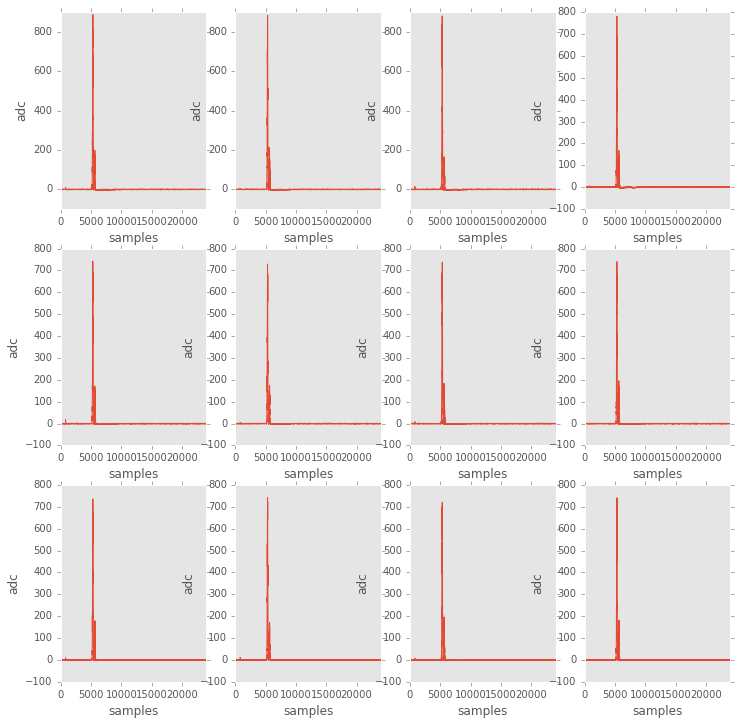

Press a key...


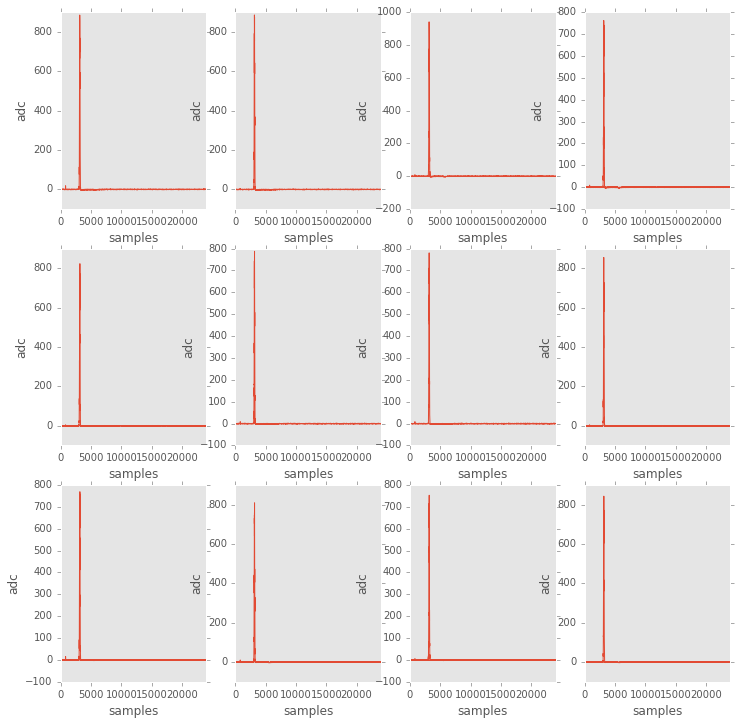

Press a key...


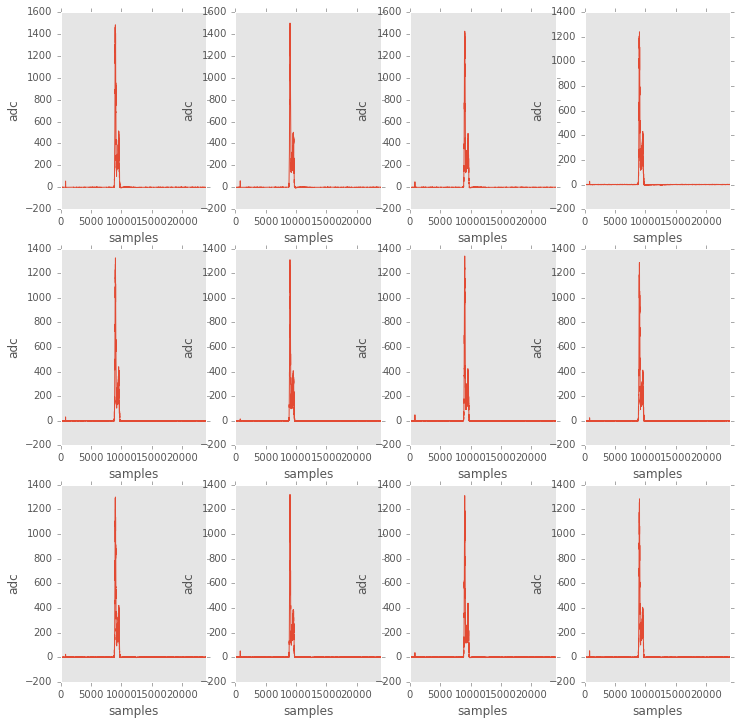

Press a key...


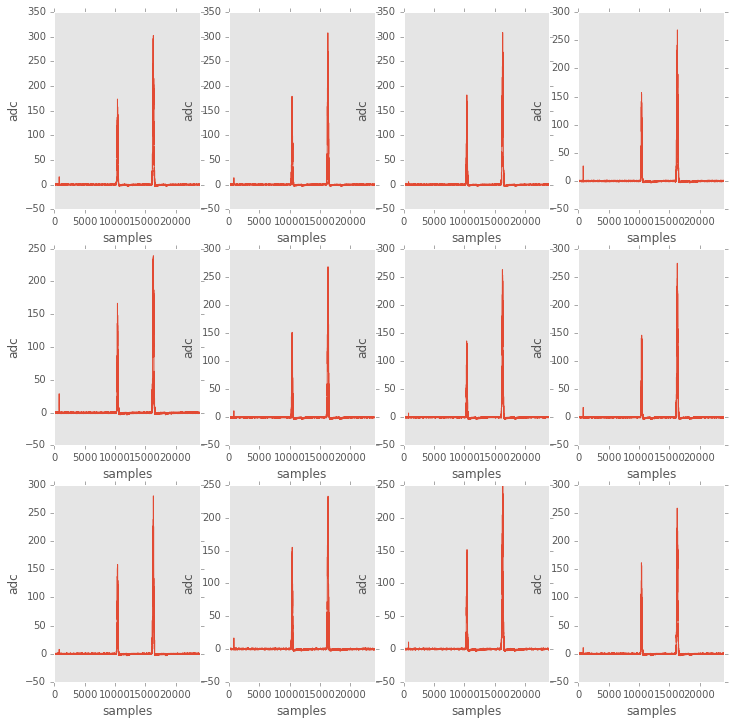

Press a key...


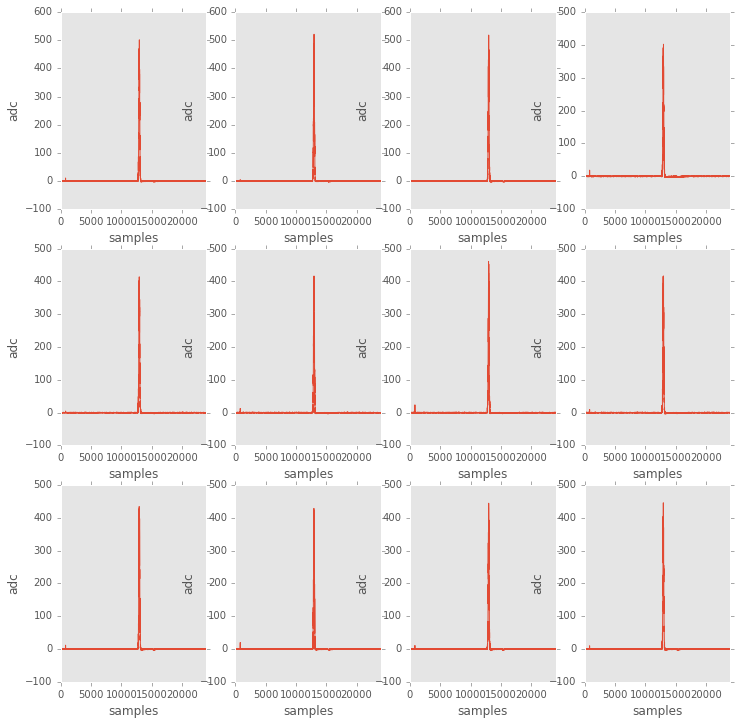

Press a key...


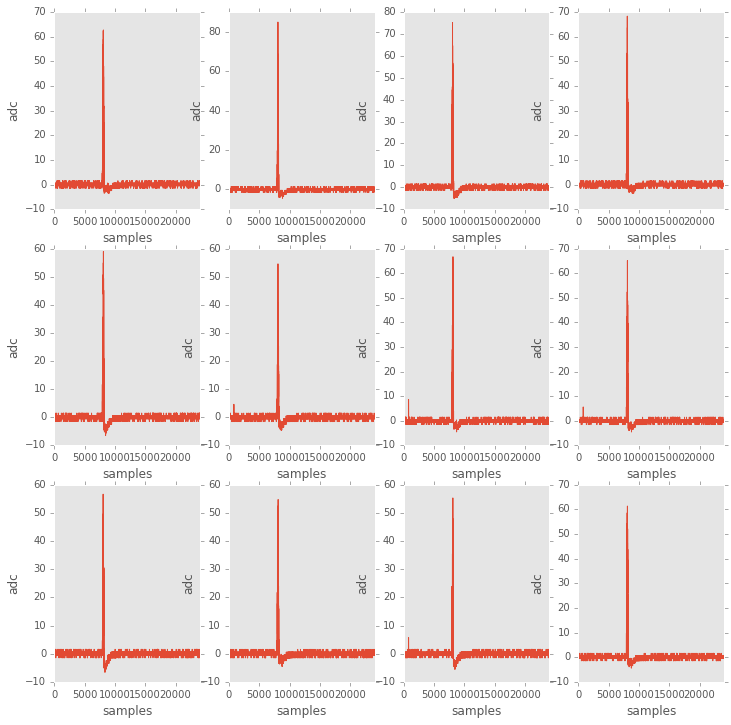

Press a key...


In [27]:
mpl.scan_waveforms(pmtcwf,list_of_events=range(6))

### Adding waveforms (calibrated)

#### add_cwf adds the waveform of each PMT in PES (divide by calibration constant) and returns a data frame

In [28]:
def wfdf(time_ns,energy_pes,indx):
    """
    takes three vectors (time, energy and indx) and returns a data frame representing a waveform
    """
    swf = {}
    swf['time_ns'] = time_ns
    swf['ene_pes'] = energy_pes 
    swf['indx'] = indx
    return pd.DataFrame(swf)

In [29]:
def add_cwf(cwfdf,pmtDF):
    """
    input: cwfdf: each colum is the wf for one PMT.
    output: swf is a data frame with two columns:
    time_ns = counts the time in ns
    ene_pes = conths the energy in pes
    """
    wf =0
    NPMT = len(pmtDF)
    for i in range(NPMT):
        adc_to_pes = pmtDF['adc_to_pes'][i]
        wf += cwfdf[i].values/adc_to_pes
    
    return wfdf(np.array(range(len(wf)))*FP.time_DAQ, wf,np.array(range(len(wf))))

In [30]:
cwfdf = wfm.get_waveforms(pmtcwf,event_number=0)
swf = add_cwf(cwfdf,PMT)

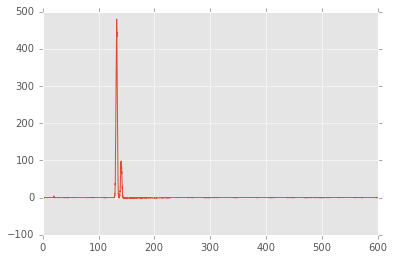

In [31]:
plt.plot(swf['time_ns']/mus, swf['ene_pes'])

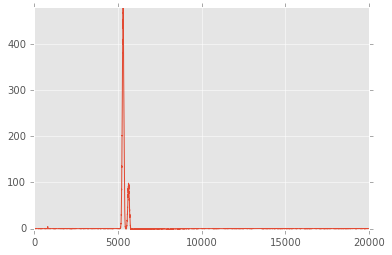

In [32]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=20000, offset=1)

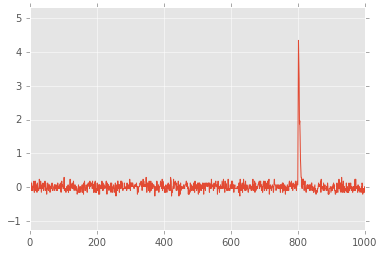

In [33]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=1000, offset=1)

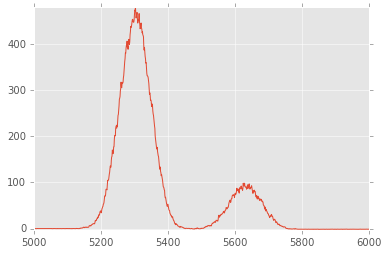

In [34]:
mpl.plts(swf['ene_pes'], signal_start=5000, signal_end=6000, offset=1)

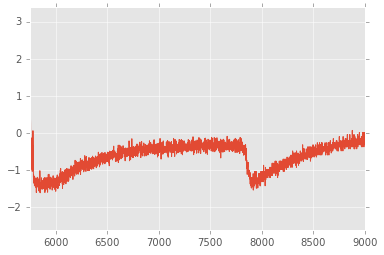

In [35]:
mpl.plts(swf['ene_pes'], signal_start=5750, signal_end=9000, offset=1)

In [36]:
ewf = sum(swf['ene_pes'].values)

In [37]:
ewf

62271.441431697458

In [40]:
cwfdf = wfm.get_waveforms(pmtcwf,event_number=1)
swf = add_cwf(cwfdf,PMT)

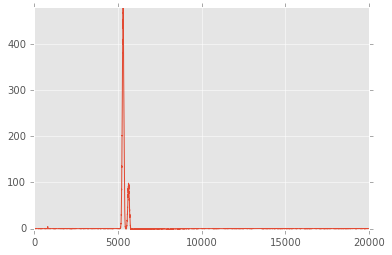

In [39]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=20000, offset=1)

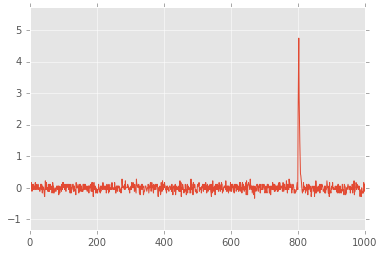

In [41]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=1000, offset=1)

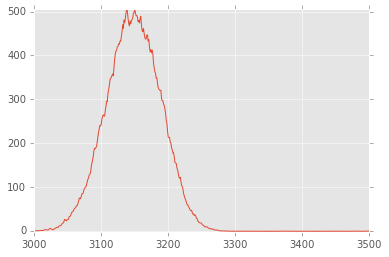

In [42]:
mpl.plts(swf['ene_pes'], signal_start=3000, signal_end=3500, offset=1)

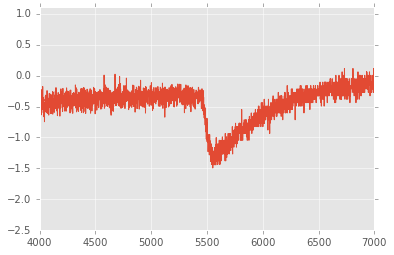

In [43]:
mpl.plts(swf['ene_pes'], signal_start=4000, signal_end=7000, offset=1)

In [44]:
def get_waveforms(pmtea,event_number=0):
    """
    Takes the earray pmtea and returns a DF for event_number
    """
    
    PMTWF ={}
    NPMT = pmtea.shape[1]
    
    for j in range(NPMT):
        PMTWF[j] = pmtea[event_number, j] #waveform for event event_number, PMT j
       
    return pd.DataFrame(PMTWF)

In [45]:
cwfdf = get_waveforms(pmtcwf,event_number=2)
swf = add_cwf(cwfdf,PMT)

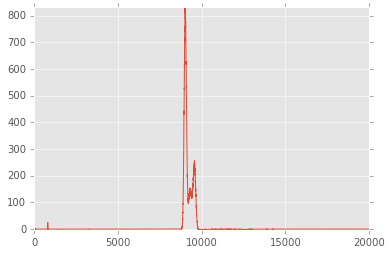

In [46]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=20000, offset=1)

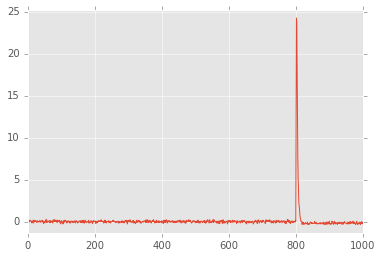

In [47]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=1000, offset=1)

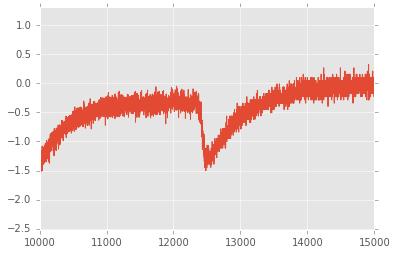

In [48]:
mpl.plts(swf['ene_pes'], signal_start=10000, signal_end=15000, offset=1)

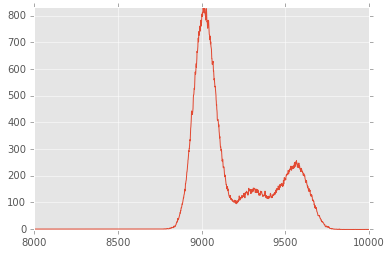

In [49]:
mpl.plts(swf['ene_pes'], signal_start=8000, signal_end=10000, offset=1)

In [50]:
cwfdf = get_waveforms(pmtcwf,event_number=3)
swf = add_cwf(cwfdf,PMT)

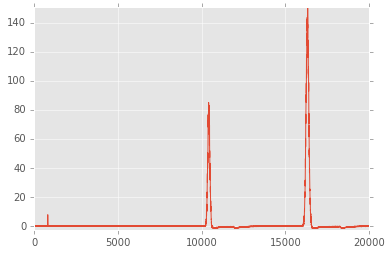

In [51]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=20000, offset=1)

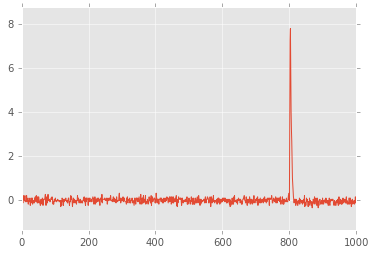

In [52]:
mpl.plts(swf['ene_pes'], signal_start=0, signal_end=1000, offset=1)

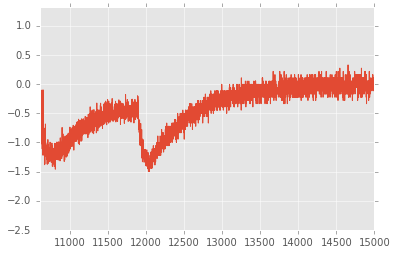

In [53]:
mpl.plts(swf['ene_pes'], signal_start=10600, signal_end=15000, offset=1)

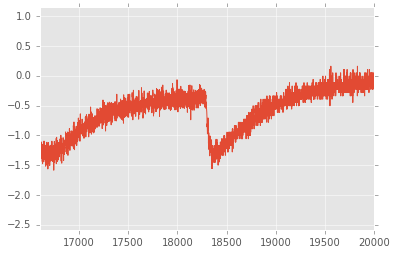

In [54]:
mpl.plts(swf['ene_pes'], signal_start=16600, signal_end=20000, offset=1)

#### Effect of baseline recovery

Tipically a dip up to -2/3 pes. The effect if more evident with a negative offset, since the subtraction of the baseline results in the dip being always negative. 

In [55]:
def scan_SWF(pmtcwf,pmtDF,list_of_events=[0]):
    for event in list_of_events:
        cwfdf = get_waveforms(pmtcwf,event_number=event)
        swf = add_cwf(cwfdf,pmtDF)
        plt.plot(swf['time_ns']/mus, swf['ene_pes'])
        plt.show()
        wait()
  

#### The problem with rebinning

Baseline recovery is a sistematic effect that is exagerated by rebinning. In the swf the baseline recovers in 1 pes, the rebinned wf recovers in 40 pes. 

### Finding S1 and S2 signals

In [56]:
def wf_thr(wf,threshold=1):
    """
    return a zero supressed waveform (more generally, the vaules of wf above threshold)
    """
    return wf.loc[lambda df: df.ene_pes.values >threshold, :]
    

In [57]:
def find_S12(swf, stride=40):
    """
    Find S1 or S2 signals. The input is a zero-supressed WF. The stride defines the contiguity criterium.
    The stride is applied to the indexes which keep the ordering of the original (non-zs) WF. 
    For example, with a stride of 40 (corresponding to steps of 1 mus for a DAQ timing of 25 ns) index 1
    and index 39 are in the same S12. 
    """
    T = swf['time_ns'].values
    P = swf['ene_pes'].values
    I = swf['indx'].values
    
    S12 = {}
    pulse_on = 1
    j=0
    
    S12[0] = []
    S12[0].append([T[0],P[0],I[0]])
    
    for i in range(1,len(swf)) :
        if swf.index[i]-stride > swf.index[i-1]:  #new s12
            j+=1
            S12[j] = []
            S12[j].append([T[i],P[i],I[i]])
        else:
            S12[j].append([T[i],P[i],I[i]])
            
    S12L=[]
    for i in S12.keys():
        S12L.append(pd.DataFrame(S12[i], columns=['time_ns','ene_pes','indx']))
    return S12L
            

### S12 search

#### Threshold

In [58]:
NPMT = len(PMT)
adc_to_pes = PMT['adc_to_pes'][0]
nsigma=3
thr = nsigma*sqrt(NPMT)*FP.NOISE_ADC/adc_to_pes

In [59]:
thr 

1.0306037788035733

In [60]:
cwfdf = get_waveforms(pmtcwf,event_number=0)
swf = add_cwf(cwfdf,PMT)
swf_zs = wf_thr(swf,threshold=thr)

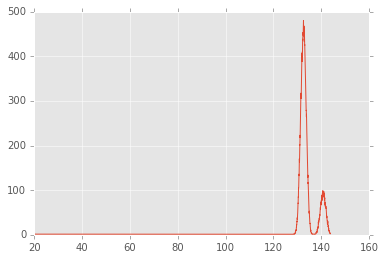

In [61]:
plt.plot(swf_zs['time_ns']/mus, swf_zs['ene_pes'])

In [62]:
s12 = find_S12(swf_zs)

In [63]:
len(s12)

2

In [64]:
s1 = s12[0]
s2 = s12[1]

In [65]:
s1

time_ns   ene_pes  indx
0  20025.0  2.391145   801
1  20050.0  4.351057   802
2  20075.0  3.812678   803
3  20100.0  3.209684   804
4  20125.0  1.875232   805
5  20150.0  1.968117   806
6  20175.0  1.488617   807

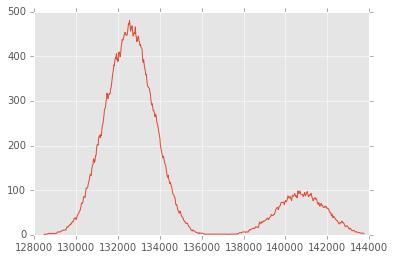

In [66]:
plt.plot(s2['time_ns'], s2['ene_pes'])

### Energy of S2

In [67]:
es2 =np.sum(s2.ene_pes.values)

In [68]:
print(" ewf = {} pes; es2 = {} pes ".format(ewf,es2))

 ewf = 62271.4414317 pes; es2 = 64153.3759527 pes 


#### Notice that es2 > ewf, since we are eliminating the negative dip associated to the BLR

### An example with two S2

##### For the following examples we use the same functions already saved in wfmFunctions.py

In [69]:
cwfdf = wfm.get_waveforms(pmtcwf,event_number=3)
swf = wfm.add_cwf(cwfdf,PMT)
swf_zs = wfm.wf_thr(swf,threshold=thr)

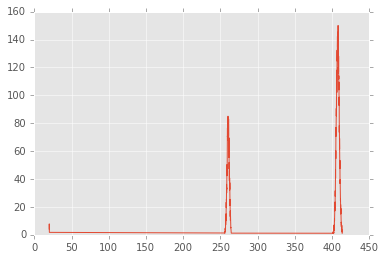

In [70]:
plt.plot(swf_zs['time_ns']/mus, swf_zs['ene_pes'])

In [71]:
s12 = find_S12(swf_zs)

In [72]:
len(s12)

3

In [73]:
s1=s12[0]
s2_1=s12[1]
s2_2=s12[2]

In [74]:
s1

time_ns   ene_pes  indx
0  20025.0  4.098535   801
1  20050.0  7.287999   802
2  20075.0  7.807946   803
3  20100.0  5.881778   804
4  20125.0  4.051884   805
5  20150.0  3.225435   806
6  20175.0  2.691952   807
7  20200.0  1.743132   808

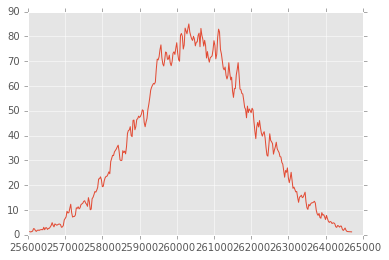

In [75]:
 plt.plot(s2_1['time_ns'],s2_1['ene_pes'])

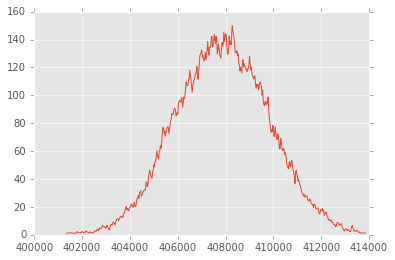

In [76]:
plt.plot(s2_2['time_ns'],s2_2['ene_pes'])

### An example with a long S2

In [77]:
len(s12)

3

In [78]:
stride = 40
print("thr = {} pes; srtide = {}".format(thr,stride))
cwfdf = wfm.get_waveforms(pmtcwf,event_number=2)
swf = wfm.add_cwf(cwfdf,PMT)
swf_zs = wfm.wf_thr(swf,threshold =thr)
s12 = wfm.find_S12(swf_zs, stride=stride)

thr = 1.0306037788 pes; srtide = 40


In [79]:
s1 = s12[0]
s2 = s12[1]

In [80]:
s1

time_ns    ene_pes  indx
0   20025.0  11.841046   801
1   20050.0  24.279861   802
2   20075.0  23.657204   803
3   20100.0  17.767056   804
4   20125.0  11.977613   805
5   20150.0   7.662593   806
6   20175.0   5.126217   807
7   20200.0   4.043209   808
8   20225.0   2.433173   809
9   20250.0   1.829800   810
10  20275.0   1.647007   811

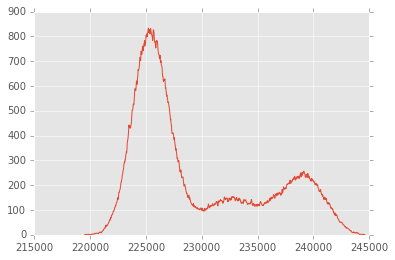

In [81]:
plt.plot(s2['time_ns'], s2['ene_pes'])

### Rebinning waveforms

In [82]:
def rebin_waveform(swf, stride = 40):
    """
    rebins the a waveform according to stride 
    The input waveform is a vector such that the index expresses time bin and the
    contents expresses energy (e.g, in pes)
    The function returns a DataFrame. The time bins and energy are rebinned according to stride
    """
    
    t = swf['time_ns'].values
    e = swf['ene_pes'].values
    I = swf['indx'].values
    n = len(swf)/int(stride)
    r = len(swf)%int(stride)
    
    lenb = n
    if r > 0: 
        lenb = n+1
    
    T = np.zeros(lenb)
    E = np.zeros(lenb)
    II = np.zeros(lenb, dtype=int)
    
    j=0
    for i in range(n):
        E[i] = np.sum(e[j:j+stride])
        T[i] = np.mean(t[j:j+stride])
        II[i] = I[(j+stride)/2]
        j+= stride
        
    if r > 0:
        E[n] = np.sum(e[j:])
        T[n] = np.mean(t[j:])
        II[n] = I[(len(swf) - j/2)]
    
   
    rbw={}
    rbw['ene_pes'] = E
    rbw['time_ns'] = T
    rbw['indx'] = II
    return pd.DataFrame(rbw)
    

##### S1 does not need to be rebinned, rebin only applies to S2

In [83]:
s2rb = rebin_waveform(s2, stride = 40)

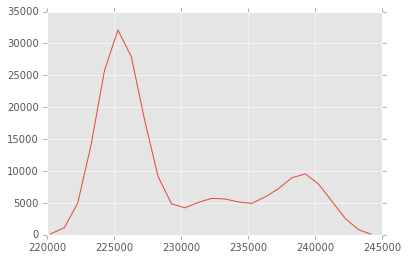

In [84]:
plt.plot(s2rb['time_ns'], s2rb['ene_pes'])

In [85]:
print("ene s2 = {} pes; ene s2rb = {} pes (must be the same)".format(np.sum(s2.ene_pes.values), 
                                                                     np.sum(s2rb.ene_pes.values)))

ene s2 = 217032.131104 pes; ene s2rb = 217032.131104 pes (must be the same)


###  t0 from S1

In [86]:
def find_t0(s1):
    """
    returns t0
    """
    emax = np.amax(s1.ene_pes.values)
    return s1.loc[lambda df: df.ene_pes.values ==emax, :]

In [87]:
print("t0 = {} mus".format(find_t0(s1).time_ns.values[0]/mus))

t0 = 20.05 mus


#### Energy and length of S2

In [88]:
def s2_energy(s2):
    """
    total energy in pes
    """
    return np.sum(s2.ene_pes.values)

In [89]:
def s2_length(s2):
    """
    s2 length in ns
    """
    t = s2.time_ns.values
    return t[-1] - t[0]

In [90]:
print('s2 energy = {} pes; s2 length = {} mus'.format(s2_energy(s2), s2_length(s2)/mus))

s2 energy = 217032.131104 pes; s2 length = 25.075 mus


In [91]:
print('s2rb energy = {} pes; s2rb length = {} mus'.format(s2_energy(s2rb), s2_length(s2rb)/mus))

s2rb energy = 217032.131104 pes; s2rb length = 23.9091666667 mus


#### Notice that rebinning introduces an error (of the order of the stride, e.g, 1 mus) in the length of s2.

### EP PMAPS

Compute now the PMAPS in the EP.
A EP PMAP is defined as the collection of S2 (bins of 1 mus) in each PMT of the EP. The collection is built
using the s2 obtained with the PMT sum 

In [92]:
def pmt_wf(cwfdf,pmtDF):
    """
    input: cwfdf: each colum is the wf for one PMT.
    output: wf is a list of waveform data frames
    time_ns = counts the time in ns
    ene_pes = conths the energy in pes
    returns a data frame with one data frame per PMT
    each pmt DF expresses the waveform in the PMT
    """
    
    NPMT = len(pmtDF)
    PMTWF = []
    for i in range(NPMT):
        adc_to_pes = pmtDF['adc_to_pes'][i]
        wf = cwfdf[i].values/adc_to_pes
        PMTWF.append(wfdf(np.array(range(len(wf)))*FP.time_DAQ, wf,np.array(range(len(wf)))))
    
        
    return PMTWF

In [93]:
pmtwf = pmt_wf(cwfdf,PMT)

In [94]:
def plot_pmtwf(PMTWF):
    """
    Plots pmtwf
    """
    
    pmtwf = PMTWF[0]
    plt.plot(pmtwf['time_ns']/mus,pmtwf['ene_pes'])
    ene = pmtwf['ene_pes'].values/12.
    time = pmtwf['time_ns'].values/mus
    plt.xlabel('t (mus)')
    plt.ylabel('E (pes)')
    plt.show()
    plt.figure(figsize=(12,12))
    for i in range(1,len(PMTWF)):
        ax1 = plt.subplot(3,4,i)
        pmtwf = PMTWF[i]
        plt.plot(pmtwf['time_ns']/mus,pmtwf['ene_pes'])
        plt.plot(time,ene)
    
    plt.show()
     
    

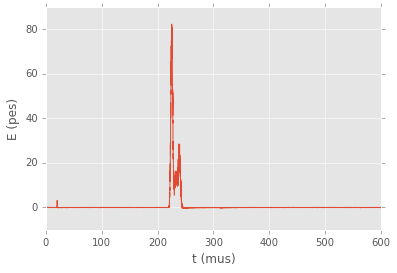

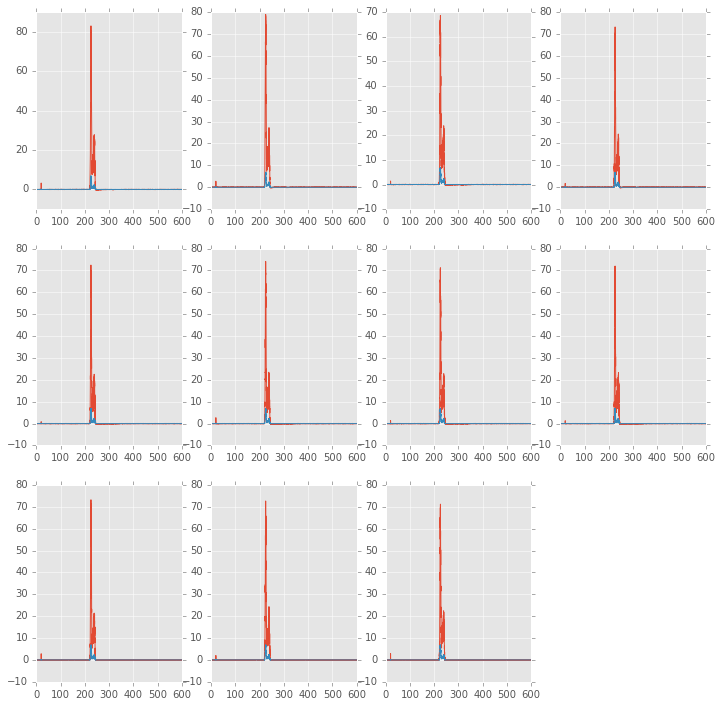

In [95]:
mpl.plot_pmtwf(pmtwf)

In [96]:
def plot_pmtwf_s2(PMTWF,s2):
    """
    Plots the pmtwf in the indexes of s2
    """
    plt.figure(figsize=(12,12))
    
    for i in range(12):
        ax1 = plt.subplot(3,4,i+1)
        pmtwf = PMTWF[i]
        plt.plot(pmtwf.time_ns.values[s2.indx.values[0]:s2.indx.values[-1]+1],
                 pmtwf.ene_pes.values[s2.indx.values[0]:s2.indx.values[-1]+1])
    
    plt.show()

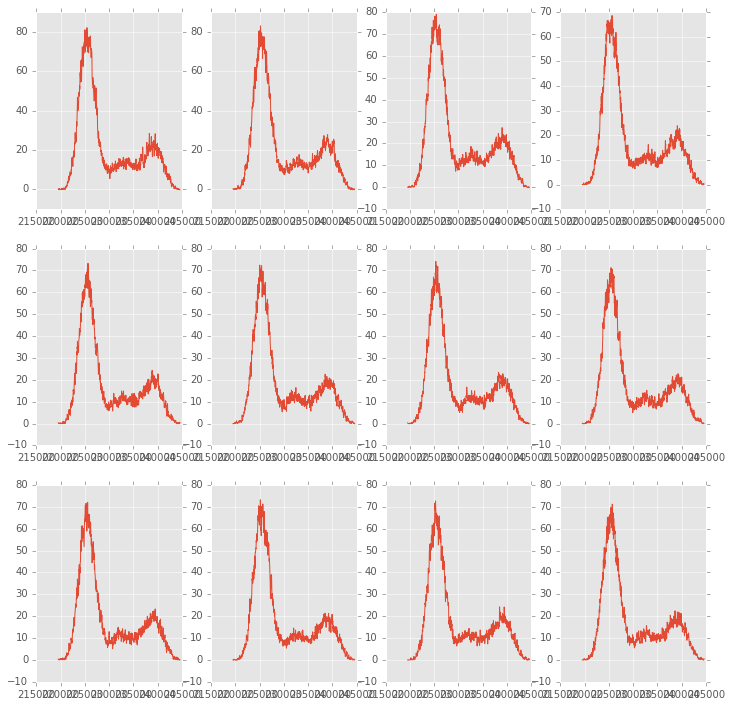

In [97]:
plot_pmtwf_s2(pmtwf,s2)

In [98]:
thr

1.0306037788035733

In [99]:
def pmaps_EP(pmtcwf,pmtDF,list_of_events=[0], thr = 1, stride=40):
    """
    computes pmaps in the EP plane
    Returns a list of S2PMAPS (one entry per event) and a t0 DataFrame
    S2PMAPS is a list of PMAPS of one entry per S2 found in the sum of PMTs
    Each EP PMAP is the collection of 12+1 S2s
    """
    NPMT = len(pmtDF)
    S2PMAP = []
    #t1 = time()
    #print('compute pmaps_EP')
    for event in list_of_events:
        #t2 = time()
        #print('event = {} time ={}'.format(event, t2-t1))
        # compute the sum function (swf), supress zeros (swf_zs) and finds s12 for swf_zs

        cwfdf = get_waveforms(pmtcwf,event_number=event)
        #t2 = time()
        #print('cwfdf: time ={}'.format(t2-t1))
        
        swf = add_cwf(cwfdf,pmtDF)
        
        #t2 = time()
        #print('swf: time ={}'.format(t2-t1))
        
        swf_zs = wf_thr(swf,threshold =thr)
        
        #t2 = time()
        #print('swf_zs time ={}'.format(t2-t1))
        
        s12 = find_S12(swf_zs, stride=stride)
        
        #t2 = time()
        #print('find_S12: time ={}'.format(t2-t1))
        
        
        is2=0
        t0 = -999
        if len(s12) > 1:  #if s1 exists is s12[0]
            is2=1  #s2 starts in index 1 if s1 exists in 0 otherwise
            s1 = s12[0]
            t0 = find_t0(s1)
        
        S2L = []
        for s2 in s12[is2:]: #loop over s2 found is swf_zs
            PMTWF = pmt_wf(cwfdf,PMT) #wf for each of the PMTs
            #scan_pmtwf_s2(PMTWF,s2)
            
            PMAP = []
            s2rb = rebin_waveform(s2, stride = stride)
            PMAP.append(s2rb)
            for i in range(NPMT):
                pmtwf = PMTWF[i]
                pmtdf = wfdf(pmtwf.time_ns.values[s2.indx.values[0]:s2.indx.values[-1]+1], 
                                 pmtwf.ene_pes.values[s2.indx.values[0]:s2.indx.values[-1]+1],
                                 pmtwf.indx.values[s2.indx.values[0]:s2.indx.values[-1]+1])
                pmtrb = rebin_waveform(pmtdf, stride = stride)
                
                PMAP.append(pmtrb)
            S2L.append(PMAP)
        S2PMAP.append(S2L)
        
        #t2 = time()
        #print('PMAP: time ={}'.format(t2-t1))
        
    return t0, S2PMAP
                                 
            

In [120]:
t0, s2pmap = pmaps_EP(pmtcwf,PMT,list_of_events=[0], thr = 1, stride=40)

In [121]:
t0

time_ns   ene_pes  indx
1  20050.0  4.351057   802

In [122]:
t0.time_ns/mus

1    20.05
Name: time_ns, dtype: float64

In [123]:
len(s2pmap)  #one event

1

In [124]:
s2p = s2pmap[0] #one S2 in sum
len(s2p)

1

In [125]:
pmap = s2p[0] #pmap has dimension 12+1
len(pmap)

13

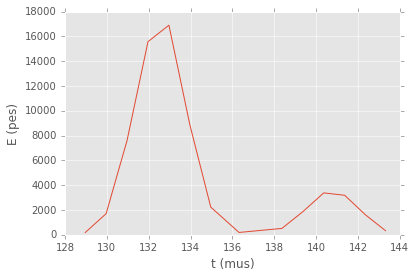

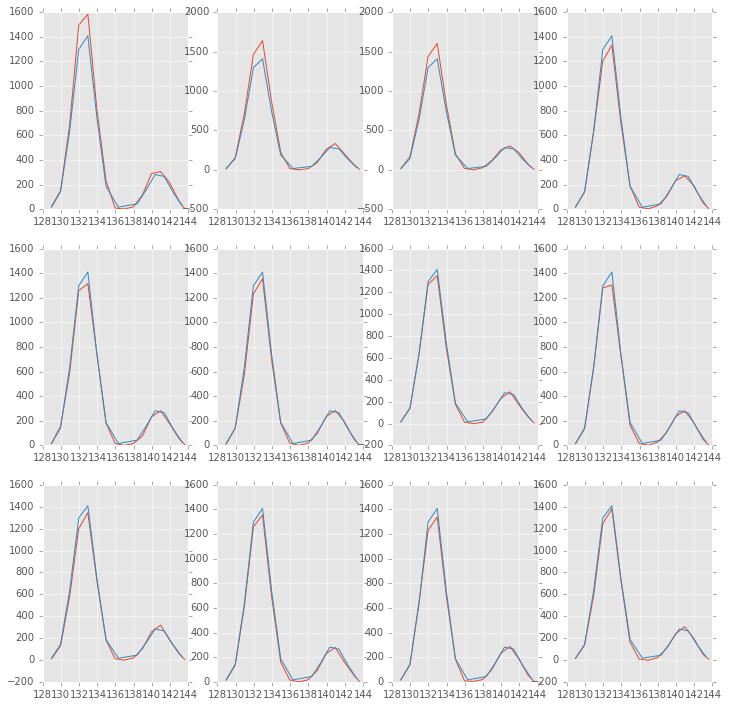

In [126]:
 plot_pmtwf(pmap)

In [129]:
t0, s2pmap = pmaps_EP(pmtcwf,PMT,list_of_events=range(5), thr = 1, stride=40)

In [130]:
len(s2pmap)

5

In [131]:
s2p = s2pmap[1]
len(s2p)

1

In [132]:
pmap = s2p[0] #pmap has dimension 12+1
len(pmap)

13

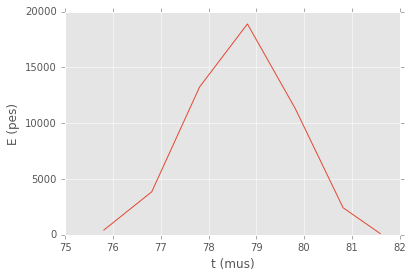

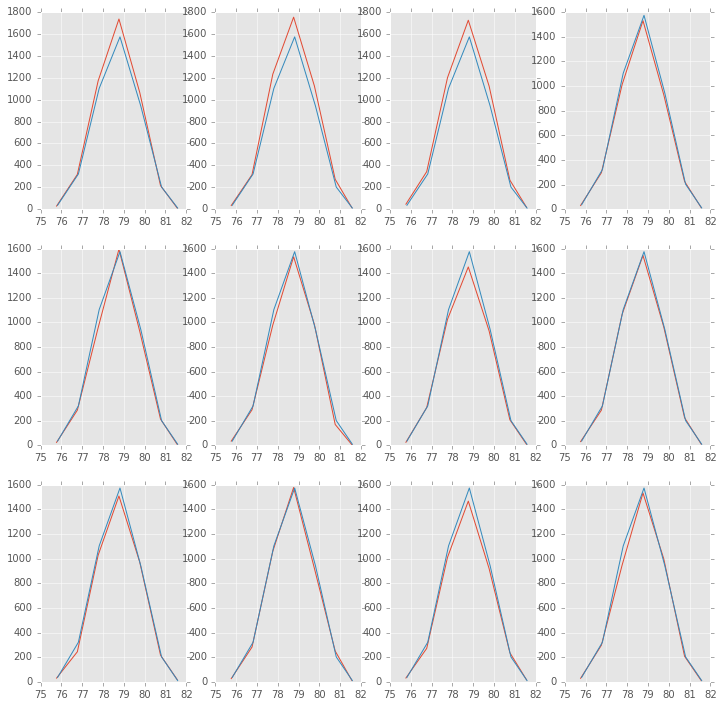

In [133]:
plot_pmtwf(pmap)

In [134]:
s2p = s2pmap[2]
len(s2p)

1

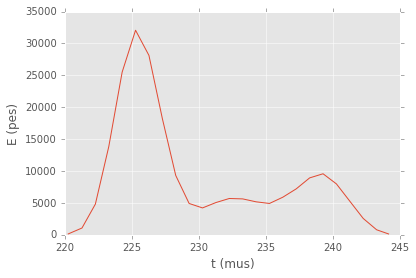

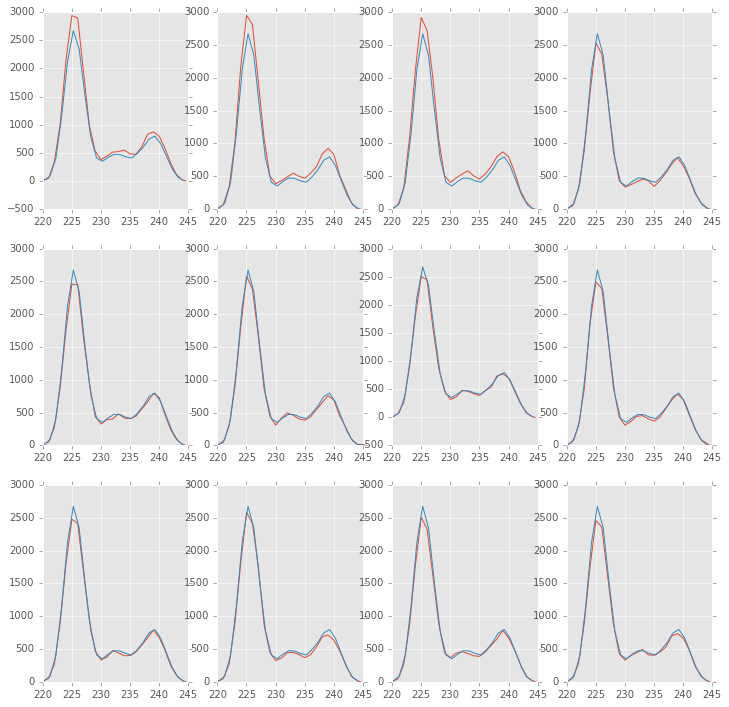

In [135]:
plot_pmtwf(s2p[0])

In [136]:
s2p = s2pmap[3]
len(s2p)

2

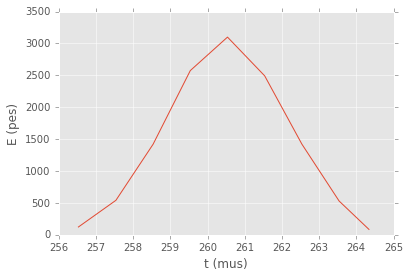

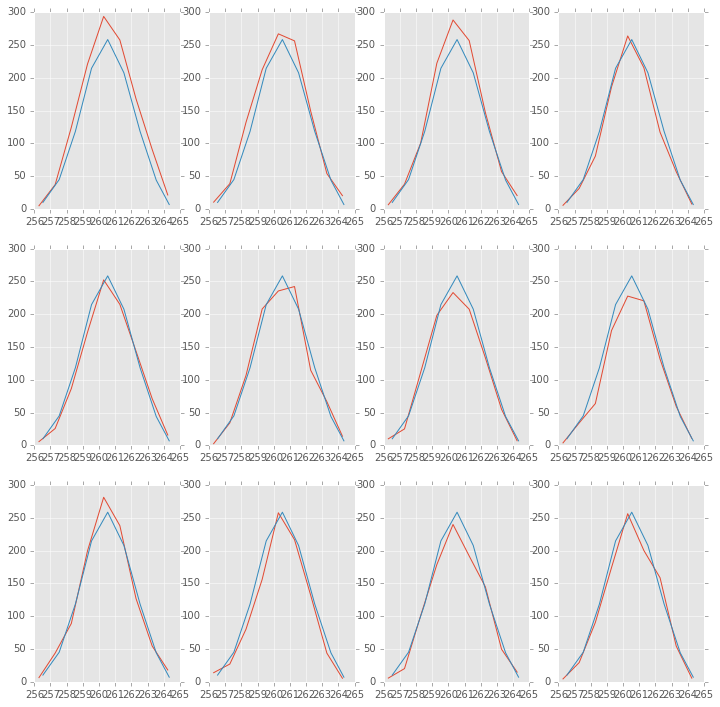

In [137]:
plot_pmtwf(s2p[0])

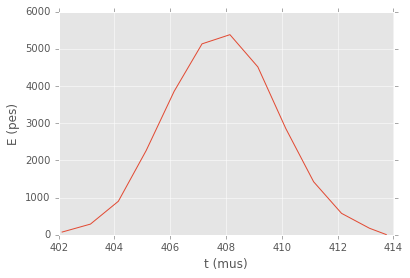

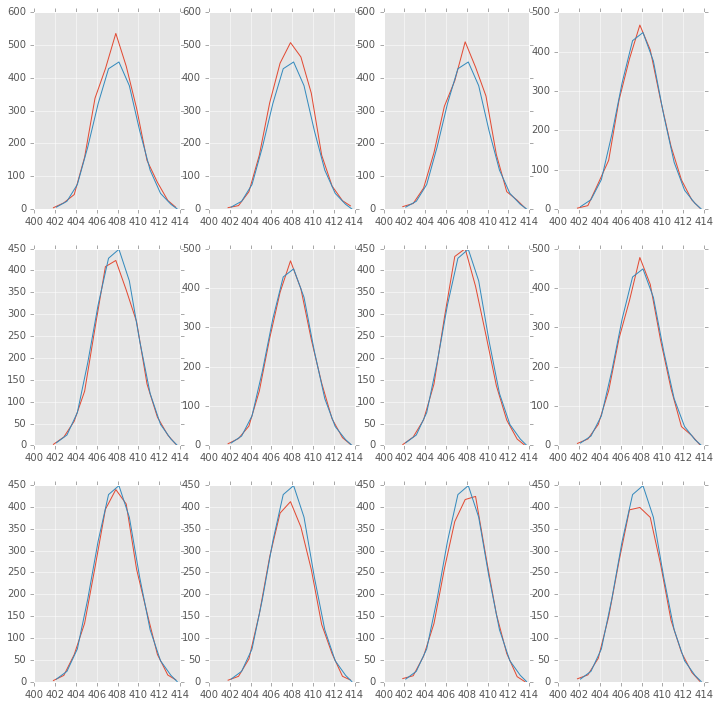

In [138]:
plot_pmtwf(s2p[1])

In [139]:
def wf_mus(wfns):
    """
    Takes as input a waveform expressed in ns and returns a waveform expressed in mus.
    """
    swf = {}
    swf['time_mus'] = wfns['time_ns']/mus
    swf['ene_pes'] = wfns['ene_pes'] 
    swf['indx'] = wfns['indx']
    return pd.DataFrame(swf)

##  SiPM PMAPS

### SiPM panel

Organize the SiPM as a PD panel, that is a collection of PD DataFrames 

1. items = number of sipm
2. One DataFrame per SiPM

In [ ]:
SIPM.adc_to_pes[2]

In [140]:
def sipm_panel(sipmrwf, SIPMDF, event_number=0):
    """
    Organize the SiPM as a PD panel, that is a collection of PD DataFrames 

    1. items = number of sipm
    2. One DataFrame per SiPM
    """
    sipmwf = sipmrwf[event_number]
    SIPM = {}
    NSIPM = sipmwf.shape[0]
    sipmwl = sipmwf.shape[1]
    for i in range(NSIPM):
        adc_to_pes = SIPMDF.adc_to_pes[i]
        energy_pes = sipmwf[i]/adc_to_pes
        time_ns = np.array(range(sipmwl))*1e+3 #steps are mus
        indx = np.ones(sipmwl)*i
        SIPM[i] = wf_mus(wfdf(time_ns,energy_pes,indx))
    return pd.Panel(SIPM)

In [141]:
sipmrwf = h5f.root.RD.sipmrwf

In [142]:
sipmrwf

/RD/sipmrwf (EArray(10, 1792, 600), shuffle, zlib(1)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 218, 600)

In [143]:
sipmwf = sipmrwf[0]

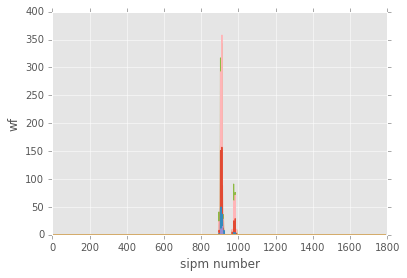

In [144]:
plt.plot(sipmwf)    
plt.xlabel('sipm number')
plt.ylabel('wf')

In [145]:
sipmwf.shape

(1792, 600)

In [146]:
%timeit sipmp = sipm_panel(sipmrwf, SIPM, event_number=0)

1 loop, best of 3: 1.68 s per loop


In [148]:
sipmp = sipm_panel(sipmrwf, SIPM, event_number=0)

In [149]:
sipmp.major_axis

RangeIndex(start=0, stop=600, step=1)

In [150]:
sipmp.minor_axis

Index([u'ene_pes', u'indx', u'time_mus'], dtype='object')

In [151]:
sipmp.items

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1782, 1783, 1784, 1785, 1786, 1787, 1788, 1789, 1790, 1791],
           dtype='int64', length=1792)

In [152]:
s2p = s2pmap[0]
pmap = s2p[0]
s2 = pmap[0]

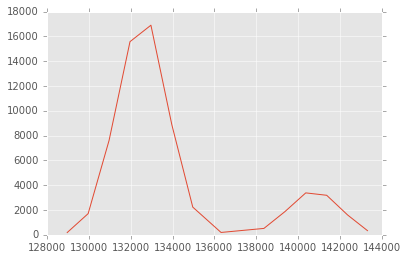

In [153]:
plt.plot(s2['time_ns'], s2['ene_pes'])

We take the s2 of the sum in bins of 1 ms and express it in mus for consistency with the SiPM plane

In [154]:
s2mus = wf_mus(s2)

In [155]:
s2mus.time_mus.values

array([ 128.9625 ,  129.9625 ,  130.9625 ,  131.9625 ,  132.9625 ,
        133.9625 ,  134.9625 ,  136.31375,  138.3625 ,  139.3625 ,
        140.3625 ,  141.3625 ,  142.3625 ,  143.3125 ])

In [156]:
s2ti = s2mus.time_mus.values[0]
s2tf = s2mus.time_mus.values[-1]

In [157]:
s2ti

128.96250000000001

In [158]:
s2tf

143.3125

For each sipm in the TP we select only the bins defined by s2

In [159]:
sipm =sipmp[0]

In [160]:
def sipm_s2(sipmdf, s2df):
    """
    Takes a sipm DF and an s2df
    Returns a DF with the sipm values in the range specified by s2
    """
    s2ti = s2df.time_mus.values[0]
    s2tf = s2df.time_mus.values[-1]
    dfl = sipmdf.loc[lambda df: df.time_mus.values >= s2ti, :]
    dfu = dfl.loc[lambda df: df.time_mus.values < s2tf, :]
    return dfu


In [169]:
def sipmp_s2(sipmp, s2df, thr=0.5):
    """
    Takes a sipm panel and a s2df
    Returns a sipm panel with a collection of sipm DF such that:
    1. the range of the sipm is specified by s2
    2. the sipm energy are above threshold.
    """
    SIPM={}
    j=0
    for i in sipmp.items:
        sipm = sipmp[i]
        sipms2 = sipm_s2(sipm, s2df)
        if np.sum(sipms2).ene_pes > thr:
            SIPM[j] = sipms2
            j+=1
    return pd.Panel(SIPM)
    

In [213]:
%env IPYTHONDIR

UsageError: Environment does not have key: IPYTHONDIR


In [214]:
%ls

BLR.ipynb              DOROTEA-PMAPS.ipynb    MCWF_MP.ipynb
DIOMIRA.ipynb          ISIDORA-BLR.ipynb      NDM.ipynb
DIOMIRA_K.ipynb        ISIDORA.ipynb          Nh5-Event-Model.ipynb
DIOMIRA_MP.ipynb       ISIDORA_K.ipynb        SIERPE.ipynb


In [219]:
%env IPYTHONDIR=/Users/jjgomezcadenas/Documents/Development/IPYTHON

env: IPYTHONDIR=/Users/jjgomezcadenas/Documents/Development/IPYTHON


In [244]:
def sipm_s2_panel(sipmrwf, SIPMDF, s2df, thr_min=0.5, thr_s2 =1, event_number=0):
    """
    Takes the sipmrwf and a s2df
    Returns a sipm panel with a collection of sipm DF such that:
    1. the range of the sipm is specified by s2
    2. the sipm energy are above threshold.
    """
    
    sipmwf = sipmrwf[event_number]
    SIPM = {}
    NSIPM = sipmwf.shape[0]
    sipmwl = sipmwf.shape[1]
    
    j=0
    
    for i in range(NSIPM):
        
        adc_to_pes = SIPMDF.adc_to_pes[i]
        energy_pes = sipmwf[i]/adc_to_pes
        if np.sum(energy_pes) < thr_min:  #only worry about SiPM with energy above threshold
            continue
            
        time_ns = np.array(range(sipmwl))*1e+3 #steps are mus
        indx = np.ones(sipmwl)*i
        sipm = wf_mus(wfdf(time_ns,energy_pes,indx))
        sipms2 = sipm_s2(sipm, s2df)
        if np.sum(sipms2).ene_pes > thr_s2:
            SIPM[j] = sipms2
            j+=1
    return pd.Panel(SIPM)

In [225]:
%load_ext Cython

In [227]:
%%cython
import pandas as pd
import numpy as np
def wf_mus(wfns):
    """
    Takes as input a waveform expressed in ns and returns a waveform expressed in mus.
    """
    swf = {}
    swf['time_mus'] = wfns['time_ns']/mus
    swf['ene_pes'] = wfns['ene_pes'] 
    swf['indx'] = wfns['indx']
    return pd.DataFrame(swf)

def wfdf(time_ns,energy_pes,indx):
    """
    takes three vectors (time, energy and indx) and returns a data frame
    representing a waveform
    """
    swf = {}
    swf['time_ns'] = time_ns
    swf['ene_pes'] = energy_pes 
    swf['indx'] = indx
    return pd.DataFrame(swf)

def sipm_s2(sipmdf, s2df):
    """
    Takes a sipm DF and an s2df
    Returns a DF with the sipm values in the range specified by s2
    """
    s2ti = s2df.time_mus.values[0]
    s2tf = s2df.time_mus.values[-1]
    dfl = sipmdf.loc[lambda df: df.time_mus.values >= s2ti, :]
    dfu = dfl.loc[lambda df: df.time_mus.values < s2tf, :]
    return dfu

def sipm_s2_panel(sipmrwf, SIPMDF, s2df, thr=0.5, event_number=0):
    """
    Takes a sipm panel and a s2df
    Returns a sipm panel with a collection of sipm DF such that:
    1. the range of the sipm is specified by s2
    2. the sipm energy are above threshold.
    """
    
    sipmwf = sipmrwf[event_number]
    SIPM = {}
    NSIPM = sipmwf.shape[0]
    sipmwl = sipmwf.shape[1]
    
    j=0
    
    for i in range(NSIPM):
        
        adc_to_pes = SIPMDF.adc_to_pes[i]
        energy_pes = sipmwf[i]/adc_to_pes
        if np.sum(energy_pes) < thr:
            continue
            
        time_ns = np.array(range(sipmwl))*1e+3 #steps are mus
        indx = np.ones(sipmwl)*i
        sipm = wf_mus(wfdf(time_ns,energy_pes,indx))
        sipms2 = sipm_s2(sipm, s2df)
        if np.sum(sipms2).ene_pes > thr:
            SIPM[j] = sipms2
            j+=1
    return pd.Panel(SIPM)
    


Error compiling Cython file:
------------------------------------------------------------
...
def wf_mus(wfns):
    """
    Takes as input a waveform expressed in ns and returns a waveform expressed in mus.
    """
    swf = {}
    swf['time_mus'] = wfns['time_ns']/mus
                                        ^
------------------------------------------------------------

/Users/jjgomezcadenas/Documents/Development/IPYTHON/cython/_cython_magic_d0ac93bb4ffa39bdab1f6a44f9a00b3c.pyx:8:41: undeclared name not builtin: mus


In [170]:
%timeit sipms2p  = sipmp_s2(sipmp, s2mus, thr=0.5)

1 loop, best of 3: 1.25 s per loop


In [245]:
%timeit sipms2p = sipm_s2_panel(sipmrwf, SIPM, s2mus, thr_min=0.5, thr_s2 = 1, event_number=0)

1 loop, best of 3: 134 ms per loop


In [230]:
type(sipms2p)

pandas.core.panel.Panel

In [246]:
sipms2p = sipm_s2_panel(sipmrwf, SIPM, s2mus, thr_min=0.5, thr_s2 = 1, event_number=0)

#### SIPMS2P

A SIPMS2P is a SiPM panel selected by S2 (e.g, the S2 of the EP sum) and by energy threshold

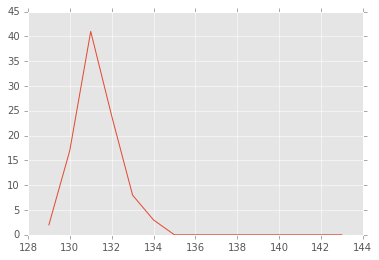

In [247]:
plt.plot(sipms2p[0].time_mus.values,sipms2p[0].ene_pes.values)

In [173]:
sipms2p[0].indx.values # all indx are the same and give the number of the sipm

array([ 896.,  896.,  896.,  896.,  896.,  896.,  896.,  896.,  896.,
        896.,  896.,  896.,  896.,  896.,  896.])

In [174]:
sipms2p[0].indx.values[0]

896.0

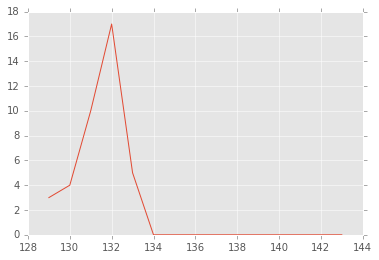

In [175]:
plt.plot(sipms2p[1].time_mus.values,sipms2p[1].ene_pes.values)

In [176]:
sipms2p[1].indx.values[0]

897.0

In [177]:
def sipm_hit_index(sipmp):
    """
    Store the indexes of the (sipm number)
    """
    hi =[]
    for i in sipmp.items:
        sipm = sipmp[i]
        hi.append(sipm.indx.values[0])
    return pd.Series(hi)

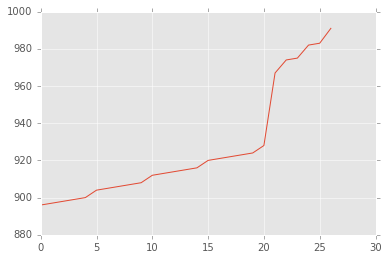

In [178]:
plt.plot(sipm_hit_index(sipms2p).values)

In [179]:
def sipmps2p_energy(sipms2p):
    """
    Takes a sipms2p as input
    Returns a DataFrame with the index and the energy in the SiPM as columns:
    
    """
    
    SIPM=[]
    for i in sipms2p.items:
        swf = {}
        swf['ene_pes'] = np.sum(sipms2p[i].ene_pes.values)
        swf['indx'] = sipms2p[i].indx.values[0]
        SIPM.append(swf)
        
    return pd.DataFrame(SIPM)

In [180]:
sipmps2p_e = sipmps2p_energy(sipms2p)

In [181]:
sipmps2p_e

ene_pes   indx
0      95.0  896.0
1      39.0  897.0
2      10.0  898.0
3      15.0  899.0
4       4.0  900.0
5     993.0  904.0
6     350.0  905.0
7     110.0  906.0
8     233.0  907.0
9      43.0  908.0
10   1104.0  912.0
11    320.0  913.0
12    128.0  914.0
13    235.0  915.0
14     43.0  916.0
15     97.0  920.0
16     44.0  921.0
17     10.0  922.0
18     25.0  923.0
19      4.0  924.0
20      2.0  928.0
21     31.0  967.0
22     12.0  974.0
23    231.0  975.0
24      9.0  982.0
25    236.0  983.0
26     29.0  991.0

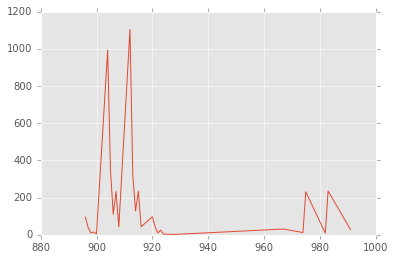

In [182]:
plt.plot(sipmps2p_e.indx.values,sipmps2p_e.ene_pes.values)

### PMAPS

#### Put together EP PMAPS and SiPM panel

###  PMAP class

In [183]:
class PMAP:
    """
    A simple class to hold the EP and TP pmap info
    """
    def __init__(self, t0):
        """
        inits the class with t0
        
        """
        
        self.t0 = t0
        self.s2PMAP  = []
        self.epPMAP  = []
        self.sipmS2P  = []
        
    def add_pmap(self,s2pmap, sipms2p, epmap):
        self.s2PMAP.append(s2pmap)
        self.sipmS2P.append(sipms2p)
        self.epPMAP.append(epmap)
    
    
    def nof_s2(self):
        return len(self.s2PMAP)
    
        
        

In [250]:
def compute_pmaps(pmtcwf,sipmrwf,PMT,SIPM,thr_s2 = 1, trh_sipm = 0.5, trh_sipm_s2 = 1, stride=40, list_of_events=[0]):
    """
    computes pmaps in the EP and SIPMS2P in the TP
    
    input:
    pmtcwf:   pmt corrected waveform
    sipmrwf:  sipm raw waveform
    PMT:      data frame with PMT constants
    thr_s2:    threshold for S2 search  in pes
    thr_sipm:    threshold for SIPM energy
    stride:   defines the rebinning: stride = 40 rebins from 25 ns to 1 mus
    """
    #t1 = time()
    #%print('calling pmaps_EP ')
    t0, s2pmap = pmaps_EP(pmtcwf,PMT,list_of_events=list_of_events, thr = thr_s2, stride=stride)
    #t2 = time()
    #print('after pmaps_EP ; time = {}'.format(t2-t1))
    
    
    event = 0
    PMAPS=[]
    #t1 = time()
    for s2p in s2pmap:   # one s2p per event
        #t2 = time()
        #print('event = {} ; time = {}'.format(event,(t2-t1)))
        
        #sipmp = sipm_panel(sipmrwf, SIPM, event_number=event) #sipm panel
        #t2 = time()
        #print('sipm panel ; time = {}'.format(t2-t1))
        pm = PMAP(t0)
        for pmap in s2p:  #each pmap corresponding to one S2 in the EP plane
            s2pmap = wf_mus(pmap[0])  #s2pmap corresponds to the sum of pmts: DF in mus
            EPMAP = []
            for s2ep in pmap[1:]:
                EPMAP.append(wf_mus(s2ep))
            sipms2p = sipm_s2_panel(sipmrwf, SIPM, s2pmap, thr_min=trh_sipm, thr_s2=trh_sipm_s2,event_number=event)
            #sipms2p  = sipmp_s2(sipmp, s2pmap, thr=trh_sipm)  #sipm2p
            pm.add_pmap(s2pmap, sipms2p, EPMAP)
        PMAPS.append(pm)
        #t2 = time()
        #print('PMAP ; time = {}'.format(t2-t1))
        event+=1
    return PMAPS
           

In [184]:
def compute_pmaps(pmtcwf,sipmrwf,PMT,SIPM,thr_s2 = 1, trh_sipm = 0.5, stride=40, list_of_events=[0]):
    """
    computes pmaps in the EP and SIPMS2P in the TP
    
    input:
    pmtcwf:   pmt corrected waveform
    sipmrwf:  sipm raw waveform
    PMT:      data frame with PMT constants
    thr_s2:    threshold for S2 search  in pes
    thr_sipm:    threshold for SIPM energy
    stride:   defines the rebinning: stride = 40 rebins from 25 ns to 1 mus
    """
    t1 = time()
    print('calling pmaps_EP ')
    t0, s2pmap = pmaps_EP(pmtcwf,PMT,list_of_events=list_of_events, thr = thr_s2, stride=stride)
    t2 = time()
    print('after pmaps_EP ; time = {}'.format(t2-t1))
    
    event = 0
    PMAPS=[]
    t1 = time()
    for s2p in s2pmap:   # one s2p per event
        t2 = time()
        print('event = {} ; time = {}'.format(event,(t2-t1)))
        sipmp = sipm_panel(sipmrwf, SIPM, event_number=event) #sipm panel
        t2 = time()
        print('sipm panel ; time = {}'.format(t2-t1))
        pm = PMAP(t0)
        for pmap in s2p:  #each pmap corresponding to one S2 in the EP plane
            s2pmap = wf_mus(pmap[0])  #s2pmap corresponds to the sum of pmts: DF in mus
            EPMAP = []
            for s2ep in pmap[1:]:
                EPMAP.append(wf_mus(s2ep))
            sipms2p  = sipmp_s2(sipmp, s2pmap, thr=trh_sipm)  #sipm2p
            pm.add_pmap(s2pmap, sipms2p, EPMAP)
        PMAPS.append(pm)
        t2 = time()
        print('PMAP ; time = {}'.format(t2-t1))
        event+=1
    return PMAPS
           
            

In [251]:
%timeit PMAPS = compute_pmaps(pmtcwf,sipmrwf,PMT, SIPM,thr_s2 =1,trh_sipm=0.5,trh_sipm_s2=1,stride=40, list_of_events=range(5))

1 loop, best of 3: 1.22 s per loop


In [252]:
PMAPS = compute_pmaps(pmtcwf,sipmrwf,PMT, SIPM,thr_s2 =1,trh_sipm=0.5,trh_sipm_s2=1,stride=40, list_of_events=range(5))

In [253]:
pmap = PMAPS[0]

In [254]:
ns2 = pmap.nof_s2()

In [255]:
ns2

1

In [256]:
s2_pmap = pmap.s2PMAP[0]
sipms2p = pmap.sipmS2P[0]
epmap = pmap.epPMAP[0]

In [257]:
s2_pmap

ene_pes  indx   time_mus
0     182.881916  5159  128.96250
1    1707.250603  5179  129.96250
2    7608.914963  5199  130.96250
3   15574.690948  5219  131.96250
4   16903.040955  5239  132.96250
5    8875.639305  5259  133.96250
6    2233.664781  5279  134.96250
7     189.473125  5299  136.31375
8     514.846301  5319  138.36250
9    1863.726412  5339  139.36250
10   3380.251366  5359  140.36250
11   3186.902031  5379  141.36250
12   1598.526224  5399  142.36250
13    334.597015  5435  143.31250

In [258]:
sipms2p

<class 'pandas.core.panel.Panel'>
Dimensions: 27 (items) x 15 (major_axis) x 3 (minor_axis)
Items axis: 0 to 26
Major_axis axis: 129 to 143
Minor_axis axis: ene_pes to time_mus

In [259]:
len(epmap)

12

In [260]:
epmap[0]

ene_pes  indx  time_mus
0     21.619734  5159  128.9625
1    150.184769  5179  129.9625
2    686.047607  5199  130.9625
3   1495.255737  5219  131.9625
4   1583.479370  5239  132.9625
5    809.008301  5259  133.9625
6    229.387955  5279  134.9625
7      9.254910  5299  135.9625
8      1.311895  5319  136.9625
9     18.251213  5339  137.9625
10   114.743546  5359  138.9625
11   289.572144  5379  139.9625
12   304.929382  5399  140.9625
13   214.182831  5419  141.9625
14    69.129021  5439  142.9625
15     2.364616  5451  143.6125

In [264]:
def ana_PMAPS(PMAPS, pmaps=1):
    event=0
    for pmap in PMAPS:
        ns2 = pmap.nof_s2()
        t0df = pmap.t0
        print('event ={}; t0 = {} mus; ns2 = {}'.format(event, t0.time_ns.values[0]/mus, ns2))
        
        for i in range(ns2):
            print('s2 number = {}'.format(i))
            s2_pmap = pmap.s2PMAP[i]
            sipms2p = pmap.sipmS2P[i]
            epmap = pmap.epPMAP[i]
            print('dimension of EP PMAP = {}'.format(len(epmap)))
            plot_s2pmap(s2_pmap)
            plot_epmap(epmap)
            plot_sipms2p_energy(sipms2p)
            wait()
        
        if event >= pmaps:
            break
        event+=1
        
        
            
        


event =0; t0 = 20.075 mus; ns2 = 1
s2 number = 0
dimension of EP PMAP = 12


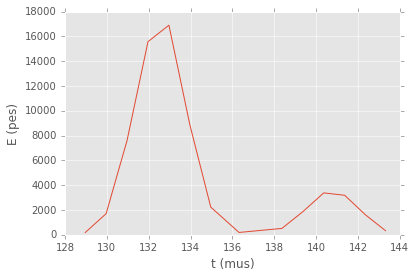

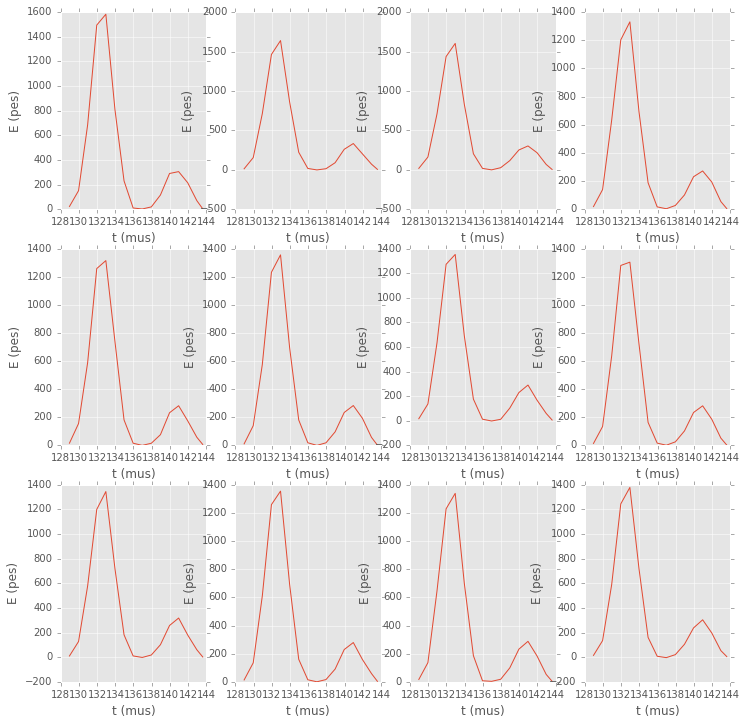

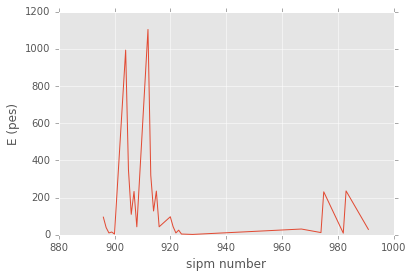

Press a key...
event =1; t0 = 20.075 mus; ns2 = 1
s2 number = 0
dimension of EP PMAP = 12


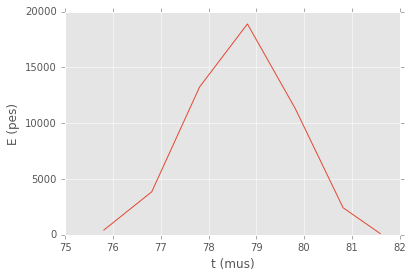

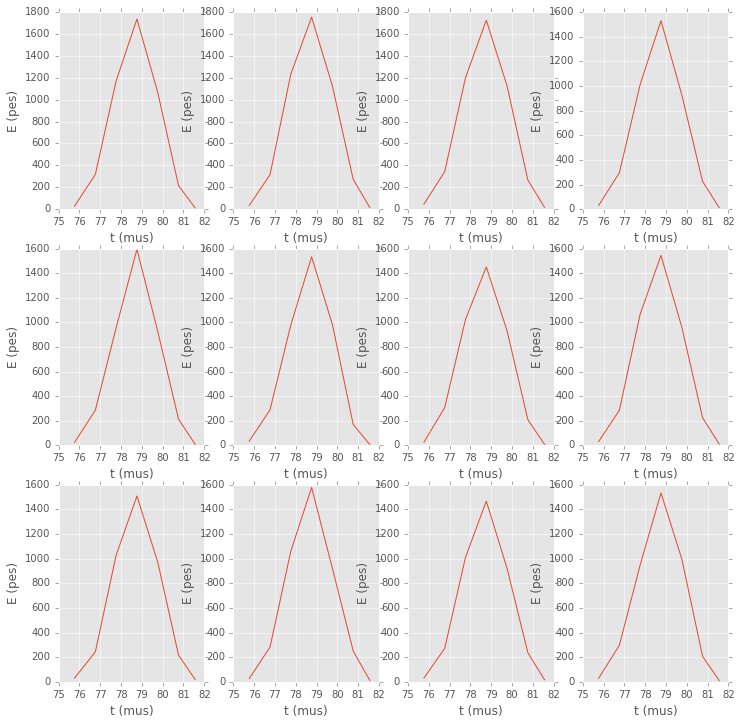

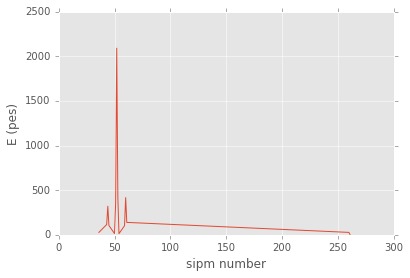

Press a key...


In [265]:
ana_PMAPS(PMAPS, pmaps=1)

In [261]:
def histo_S12(s12df, nbins=10):
    """
    histograms for s12 DF
    """
    HSimple1(s12df.ene_pes,nbins,title='energy pes',xlabel = 'ene')
    HSimple1(s12df.lmax_mus,nbins,title='track  length (mus)',xlabel = 'lmax (mus)')
    HSimple1(s12df.n_s2,nbins,title='number of S2',xlabel = 'n S2')
    HSimple1(s12df.t0_mus,nbins,title='t0',xlabel = 't (mus)')
    
    plt.show()
    

In [ ]:
histo_S12(t0_zs, nbins=10)

In [194]:
%ls ../../../data/Na

WF_Na_test_DST.h5  WF_Na_test_RWF.h5


In [195]:
% rm -f ../../../data/Na/WF_Na_test_DST.h5

In [196]:
def plot_epmap(epmap):
    """
    Plots pmaps in ep
    """
    plt.figure(figsize=(12,12))
    for i in range(1,len(epmap)+1):
        ax1 = plt.subplot(3,4,i)
        pmtwf = epmap[i-1]
        plt.xlabel('t (mus)')
        plt.ylabel('E (pes)')
        plt.plot(pmtwf['time_mus'],pmtwf['ene_pes'])
    
    plt.show()

In [197]:
def plot_s2pmap(s2pmap):
    """
    Plot s2 pmap
    """
    
    plt.plot(s2pmap['time_mus'],s2pmap['ene_pes'])
    plt.xlabel('t (mus)')
    plt.ylabel('E (pes)')
    plt.show()

In [198]:
def plot_sipms2p_energy(sipms2p):
    """
    Plot sipms2p
    """
    sipmps2p_e = sipmps2p_energy(sipms2p)
    plt.plot(sipmps2p_e.indx.values,sipmps2p_e.ene_pes.values)
    plt.xlabel('sipm number')
    plt.ylabel('E (pes)')
    plt.show()



In [199]:
dst = pd.HDFStore('../../../data/Na/WF_Na_test_DST.h5') 

In [200]:
%time dst['PMAPS'] = pd.Series(PMAPS)

CPU times: user 20.1 ms, sys: 6.3 ms, total: 26.4 ms
Wall time: 24 ms


/usr/local/lib/python2.7/site-packages/IPython/core/magics/execution.py:1176: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->values] [items->None]

  exec(code, glob, local_ns)


In [201]:
dst.close()

In [202]:
%ls -lh ../../../data/Na/WF_Na_test_DST.h5

-rw-r--r--  1 jjgomezcadenas  staff   1.1M Sep 25 19:07 ../../../data/Na/WF_Na_test_DST.h5


In [203]:
dst = pd.HDFStore('../../../data/Na/WF_Na_test_DST.h5') 

In [204]:
sPMAPS = dst['PMAPS']

In [205]:
sPMAPS

0    <__main__.PMAP instance at 0x10c306e60>
1    <__main__.PMAP instance at 0x1095455f0>
2    <__main__.PMAP instance at 0x109fc8b90>
3    <__main__.PMAP instance at 0x109fe7710>
4    <__main__.PMAP instance at 0x10c347050>
dtype: object

event =0; t0 = 20.075 mus; ns2 = 1
s2 number = 0
dimension of EP PMAP = 12


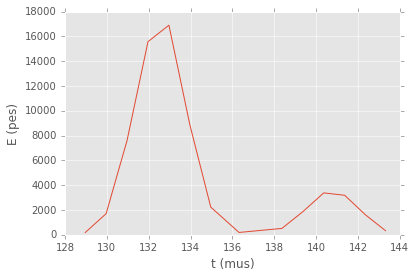

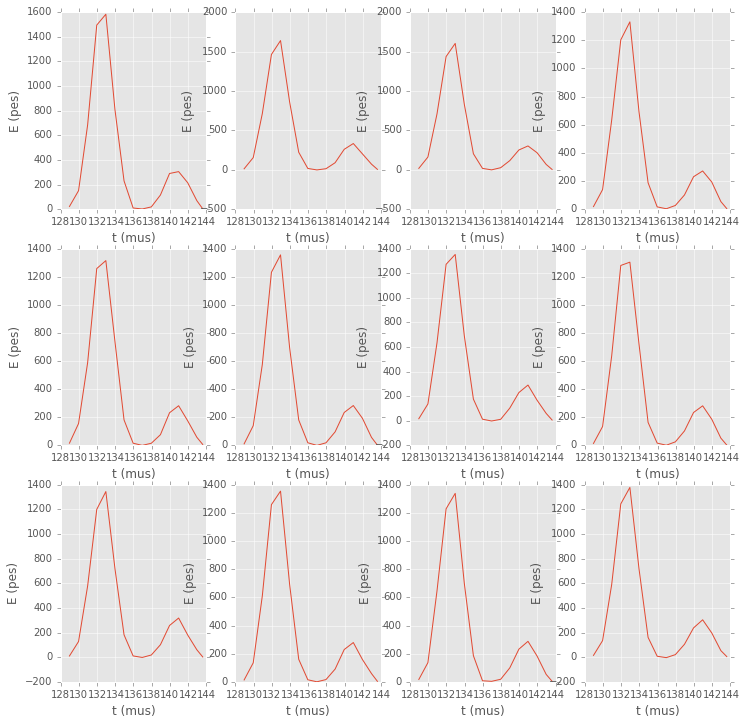

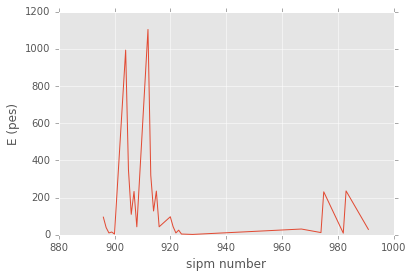

Press a key...
event =1; t0 = 20.075 mus; ns2 = 1
s2 number = 0
dimension of EP PMAP = 12


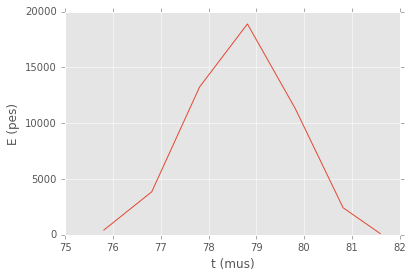

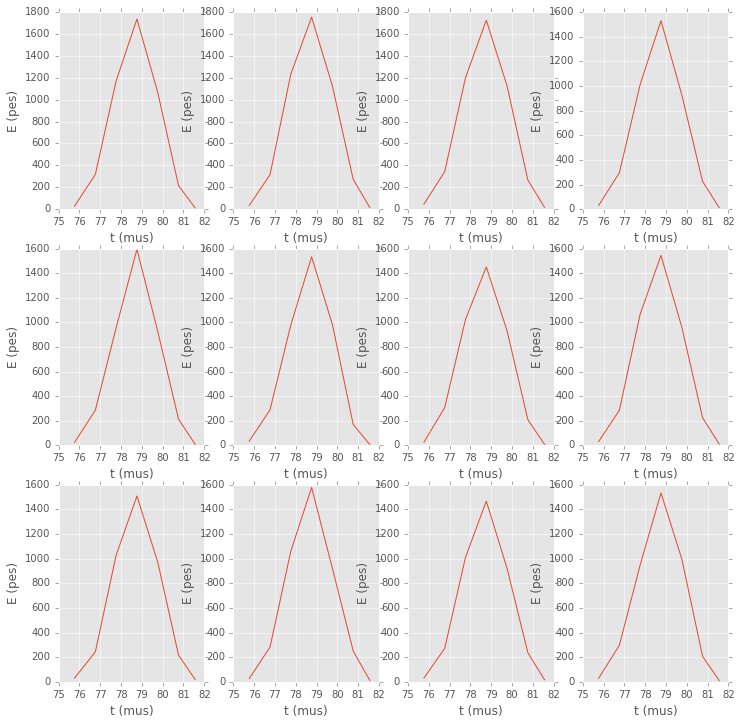

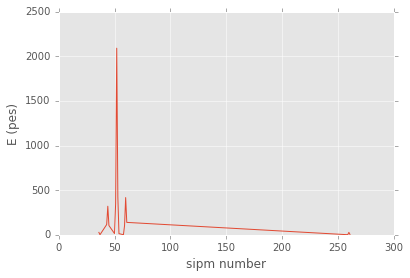

Press a key...
event =2; t0 = 20.075 mus; ns2 = 1
s2 number = 0
dimension of EP PMAP = 12


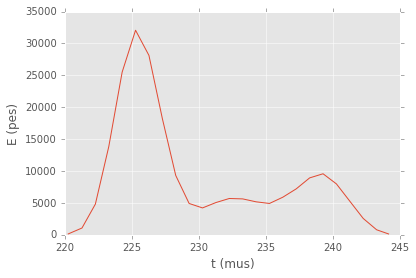

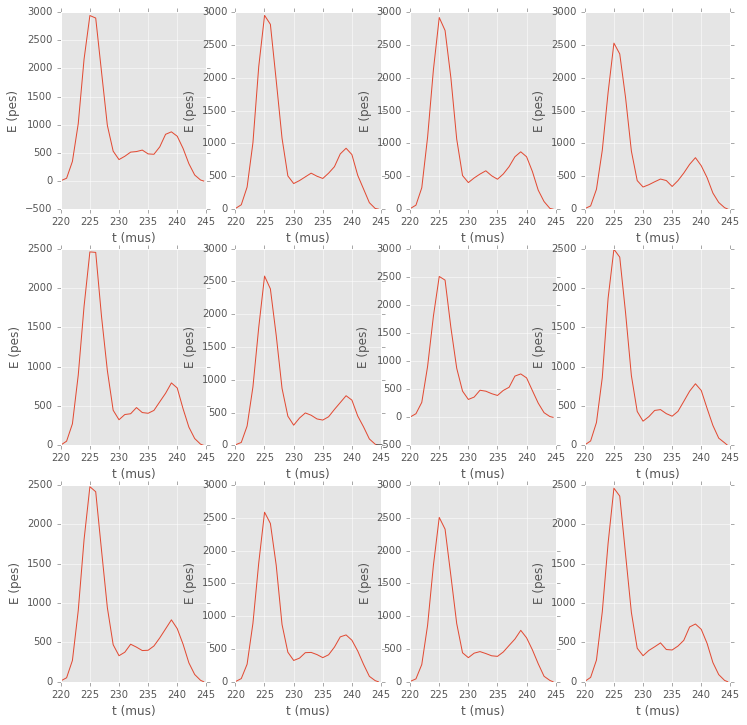

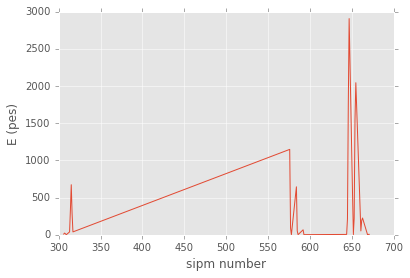

Press a key...
event =3; t0 = 20.075 mus; ns2 = 2
s2 number = 0
dimension of EP PMAP = 12


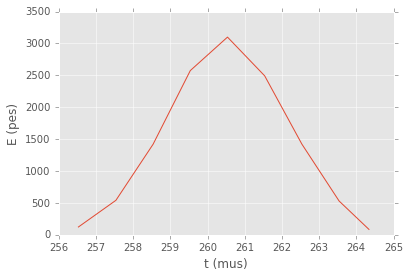

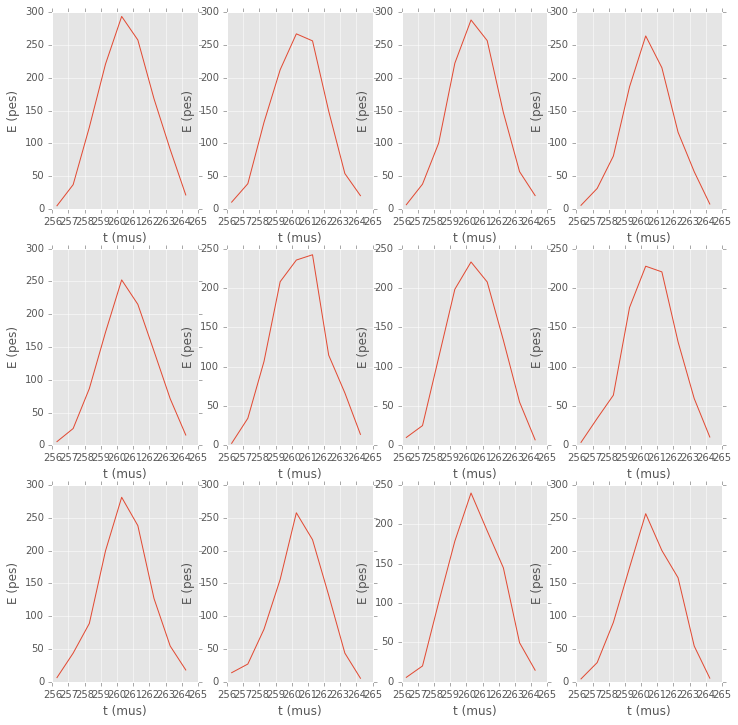

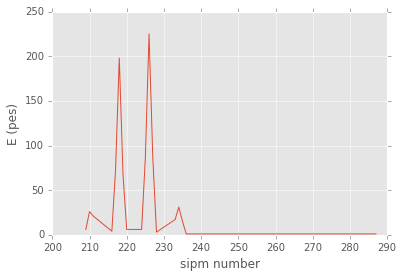

Press a key...
s2 number = 1
dimension of EP PMAP = 12


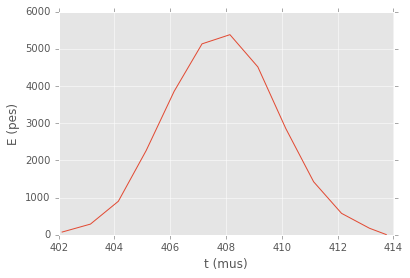

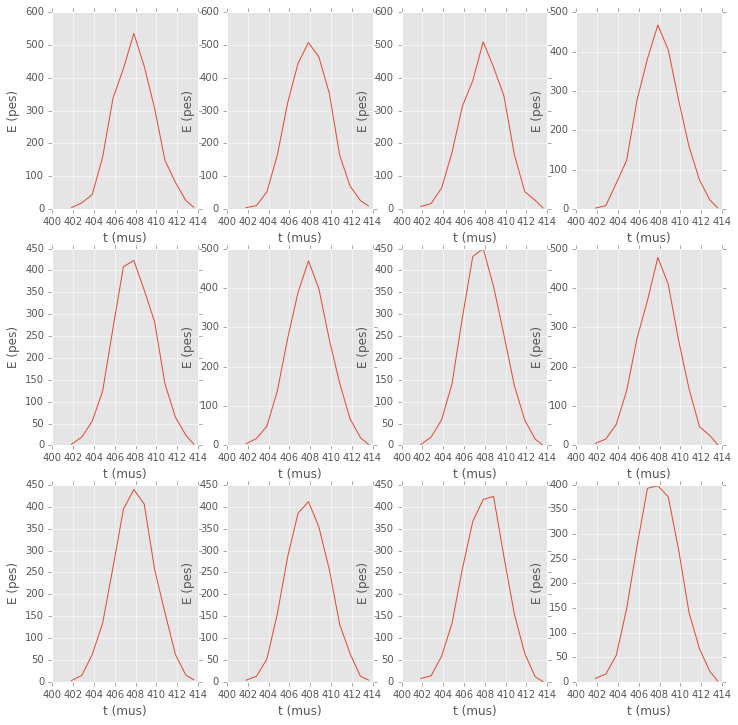

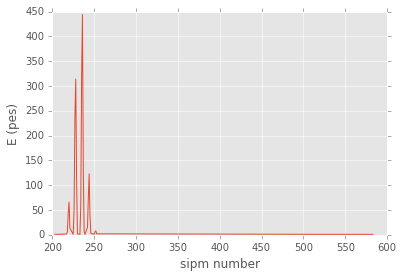

Press a key...
event =4; t0 = 20.075 mus; ns2 = 1
s2 number = 0
dimension of EP PMAP = 12


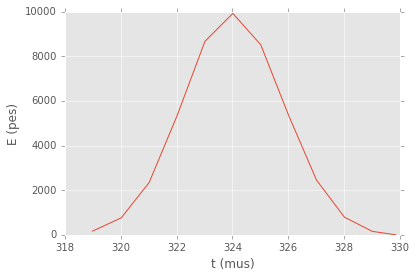

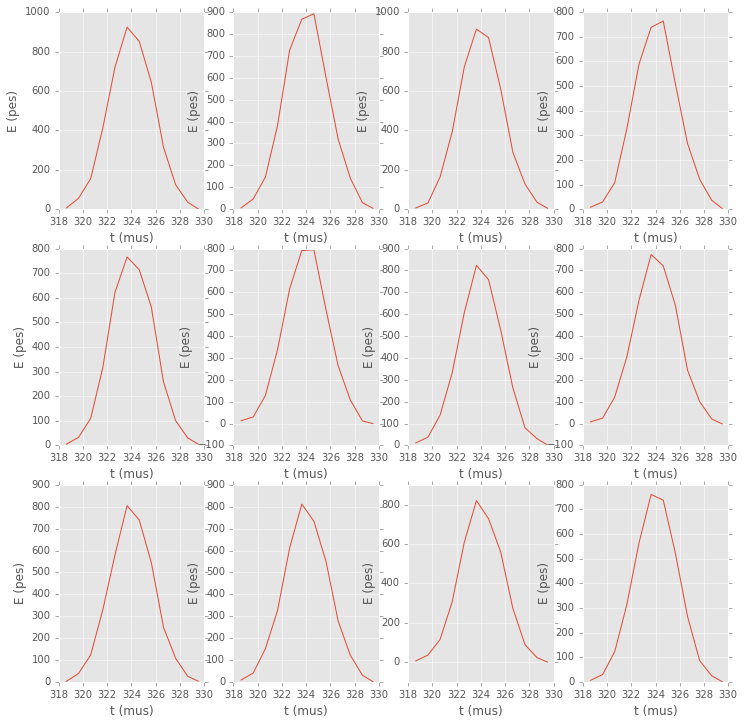

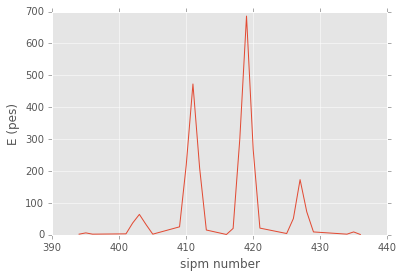

Press a key...


In [207]:
ana_PMAPS(sPMAPS.values)

event =0; t0 = 20.075 mus; ns2 = 1
s2 number = 0
dimension of EP PMAP = 12


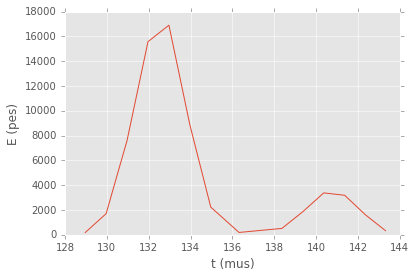

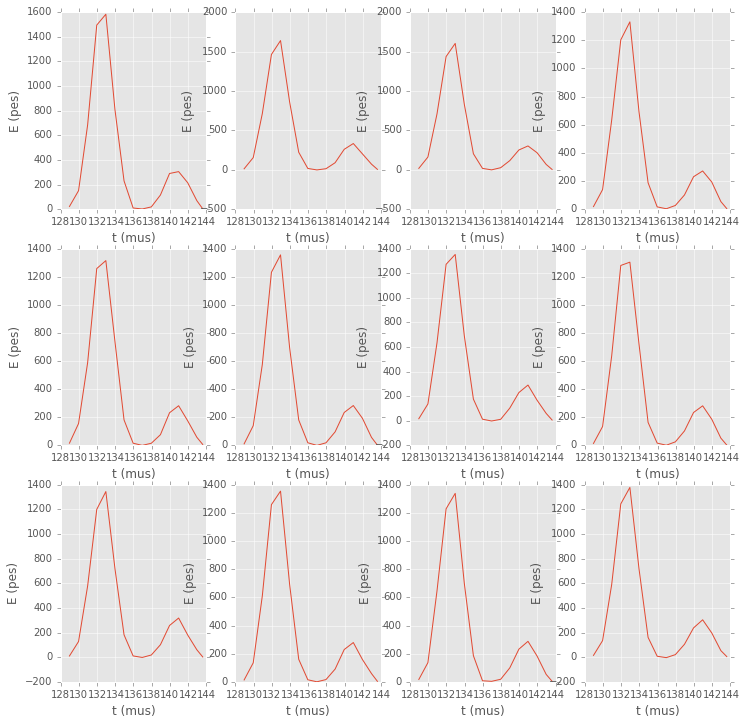

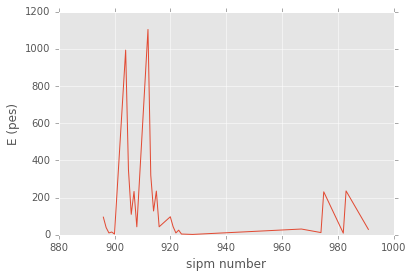

Press a key...
event =1; t0 = 20.075 mus; ns2 = 1
s2 number = 0
dimension of EP PMAP = 12


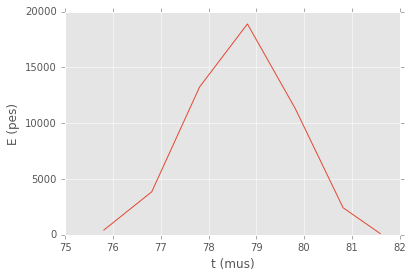

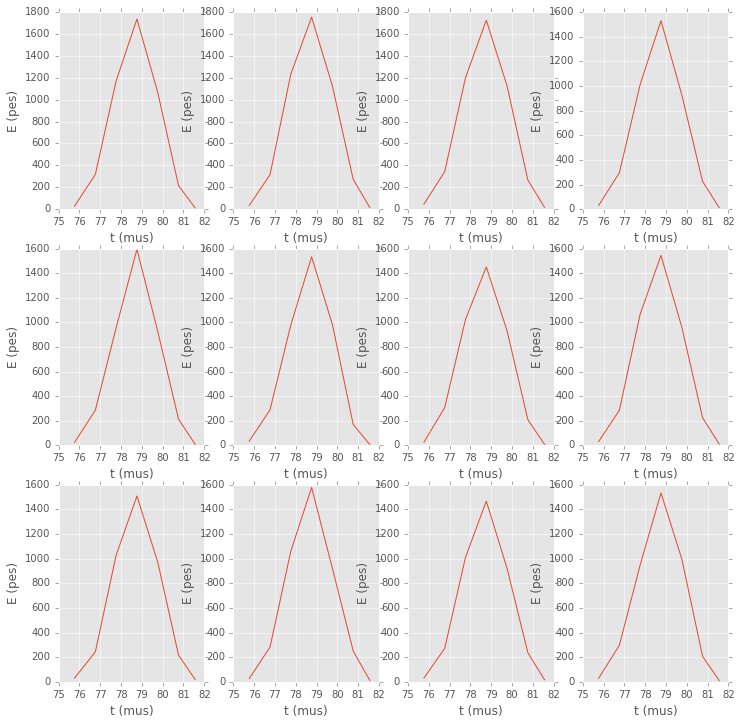

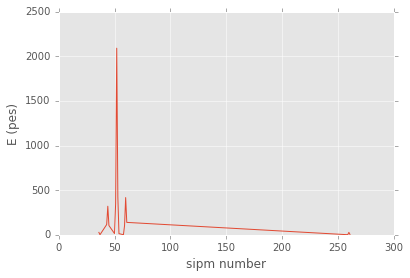

Press a key...
event =2; t0 = 20.075 mus; ns2 = 1
s2 number = 0
dimension of EP PMAP = 12


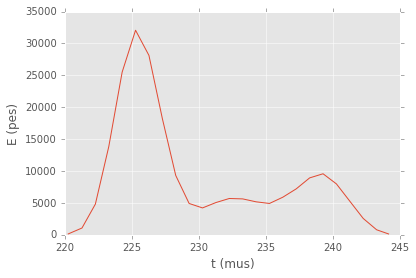

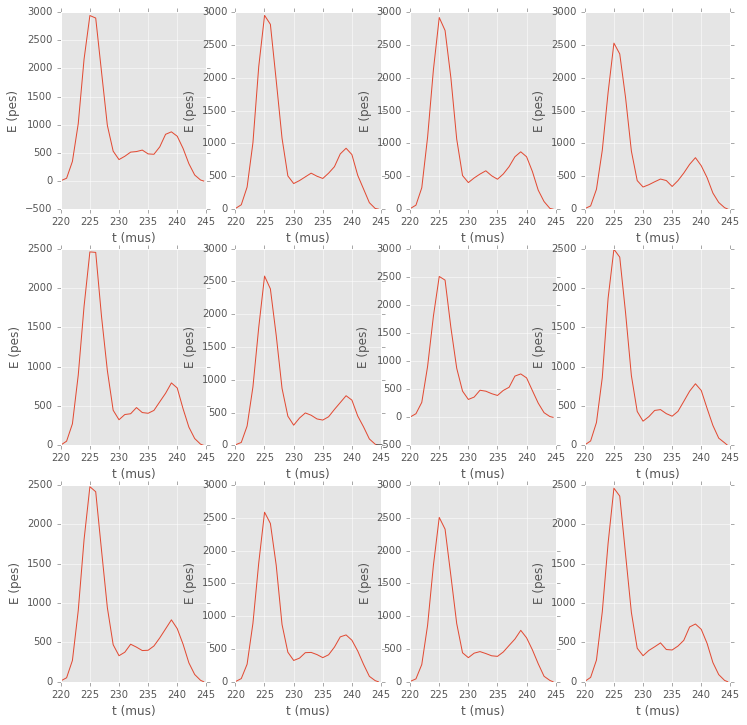

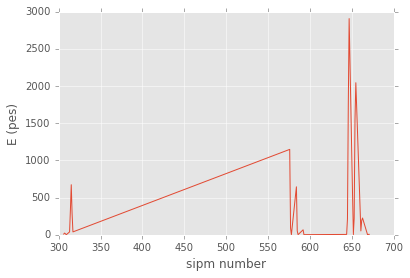

Press a key...
event =3; t0 = 20.075 mus; ns2 = 2
s2 number = 0
dimension of EP PMAP = 12


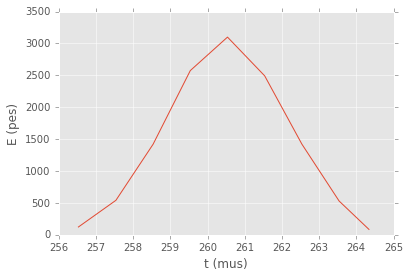

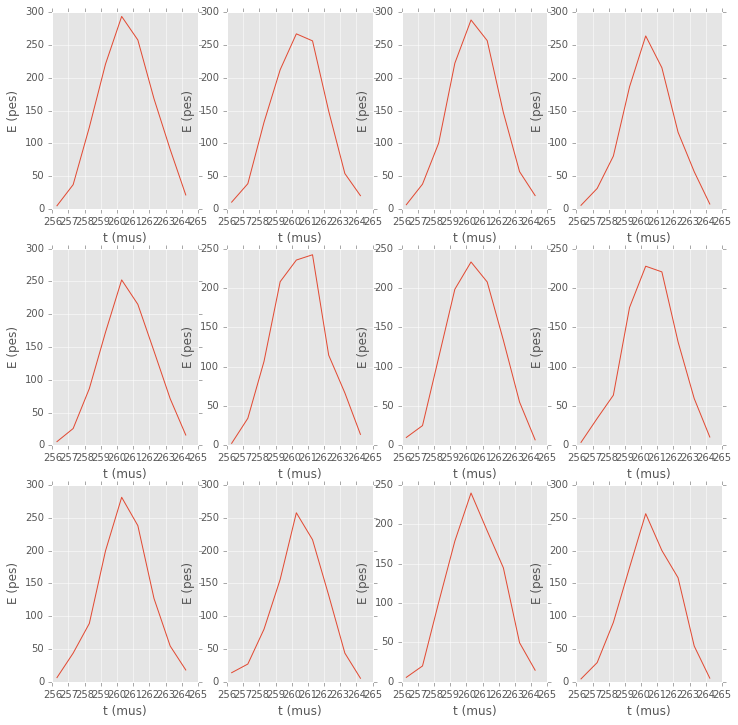

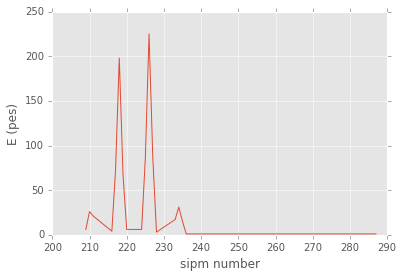

Press a key...
s2 number = 1
dimension of EP PMAP = 12


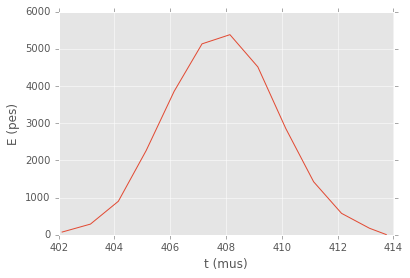

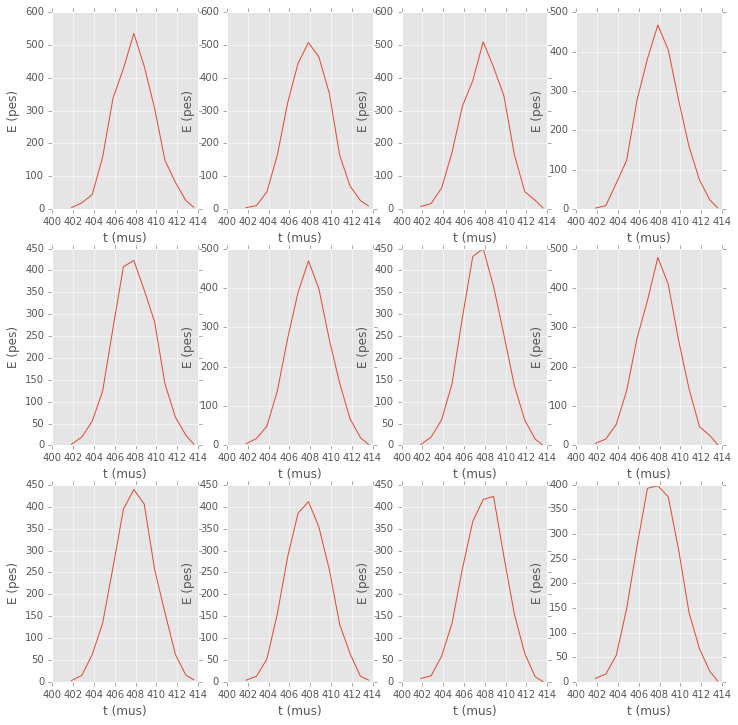

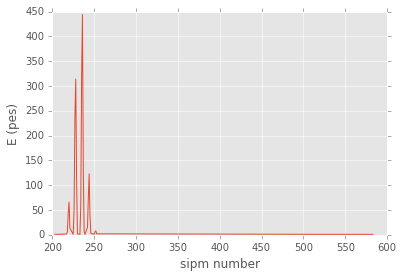

Press a key...
event =4; t0 = 20.075 mus; ns2 = 1
s2 number = 0
dimension of EP PMAP = 12


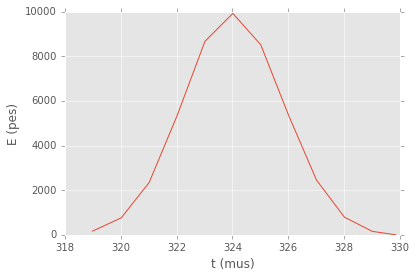

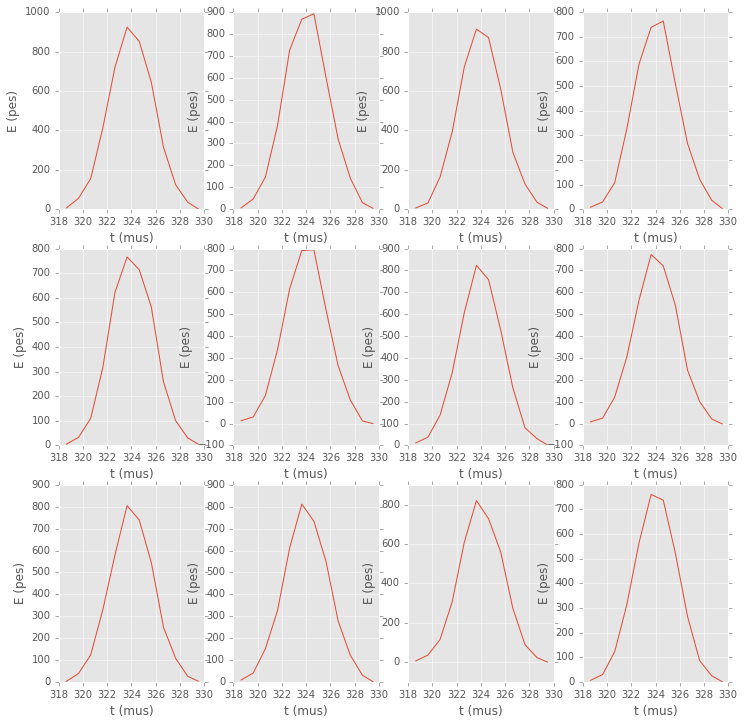

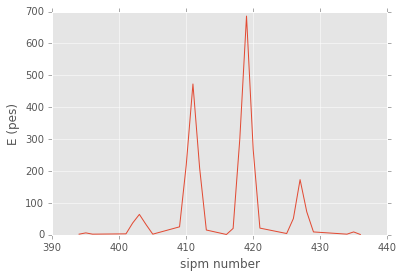

Press a key...


In [243]:
ana_PMAPS(PMAPS)

In [208]:
dst.close()

In [209]:
%ls -lh ../../../data/Na/WF_Na_test_DST.h5

-rw-r--r--  1 jjgomezcadenas  staff   1.1M Sep 25 19:07 ../../../data/Na/WF_Na_test_DST.h5
